In [3]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import mne
from mne.preprocessing import ICA

import pywt
from scipy.signal import butter, filtfilt
from scipy.fftpack import fft
from scipy.stats import skew, kurtosis

In [4]:
class paths:
    OUTPUT_DIR = "/kaggle/working/"
    TRAIN_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/train.csv"
    TRAIN_EEGS = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/"

## Read the data

In [5]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
label_cols = df.columns[-6:]
print(f"Train cataframe shape is: {df.shape}")
print(f"Labels: {list(label_cols)}")
df.head()

Train cataframe shape is: (106800, 15)
Labels: ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [6]:
# display(df)

train_df = df.groupby('eeg_id')[['spectrogram_id','eeg_label_offset_seconds']].agg({
    'eeg_label_offset_seconds':'min'
})

# display(train_df)

train_df.columns = ['min']

# display(train_df)

aux = df.groupby('eeg_id')[['eeg_label_offset_seconds']].agg({
    'eeg_label_offset_seconds':'max'
})

train_df['max'] = aux

aux = df.groupby('eeg_id')[['patient_id']].agg('first')
train_df['patient_id'] = aux

aux = df.groupby('eeg_id')[label_cols].agg('sum')
for label in label_cols:
    train_df[label] = aux[label].values
    
y_data = train_df[label_cols].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train_df[label_cols] = y_data

aux = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train_df['target'] = aux

train_df = train_df.reset_index()
print('Train non-overlapp eeg_id shape:', train_df.shape )
train_df.tail()

Train non-overlapp eeg_id shape: (17089, 11)


,eeg_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
17084,4293354003,0.0,0.0,16610,0.0,0.0,0.0,0.0,0.500000,0.500000,GRDA
17085,4293843368,0.0,0.0,15065,0.0,0.0,0.0,0.0,0.500000,0.500000,GRDA
17086,4294455489,0.0,0.0,56,0.0,0.0,0.0,0.0,0.000000,1.000000,Other
17087,4294858825,0.0,12.0,4312,0.0,0.0,0.0,0.0,0.066667,0.933333,Other
17088,4294958358,0.0,0.0,25986,0.0,0.0,0.0,0.0,0.000000,1.000000,Other


In [7]:
fname = f'{paths.TRAIN_EEGS}{4294858825}.parquet'
eeg = pd.read_parquet(fname)



coeffs = pywt.wavedec(eeg.values, 'db6', level=10, axis=0)



In [8]:
def extract_eeg_segment(eeg_id, min_time_sec, max_time_sec):
    # Load EEG data
    fname = f'{paths.TRAIN_EEGS}{eeg_id}.parquet'
    eeg = pd.read_parquet(fname)
    
    # Convert min and max time from seconds to samples
    min_sample = int(min_time_sec * 200)  # 200 Hz sampling frequency
    max_sample = int(max_time_sec * 200)
    
    # Extract EEG segment
    eeg_segment = eeg.iloc[min_sample:max_sample]
    
    return eeg_segment

In [10]:
train_df['target'].value_counts()

target
Other      7196
Seizure    2785
LPD        2577
GRDA       1828
GPD        1787
LRDA        916
Name: count, dtype: int64

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
count,12400.000000,12400.000000,12400.000000,12400.000000,12400.000000,12400.000000,12400.000000,12400.000000,12400.000000,12400.000000,12400.000000,12400.000000,12400.000000,12400.000000,12400.000000,12400.000000,12400.000000,12400.000000,12400.000000,12400.000000
mean,-582.095825,-546.828003,-473.882782,-445.661652,-97.429253,-436.053070,-567.445435,-481.705200,-535.648438,-80.202209,66.032623,-349.132874,1486.114990,-410.529999,-414.597748,-352.512848,-511.976990,-460.858154,312.419647,18.751766
std,2505.902832,1913.412109,1832.084961,1763.262207,4659.100586,1745.400513,1959.871826,1850.047729,1919.002441,4591.779297,1363.581787,1583.788940,2148.190430,3148.643311,3116.931396,1553.110229,1850.286743,2742.589355,1571.949463,449.851807
min,-15681.339844,-10950.740234,-9649.959961,-8732.129883,-13915.759766,-8319.959961,-10550.110352,-10113.500000,-10806.070312,-12079.870117,-371.089996,-5368.540039,344.730011,-13456.120117,-13916.650391,-4908.649902,-10125.950195,-15132.980469,-185.529999,-1070.959961
25%,-530.299988,-480.584999,-432.852493,-447.297508,-492.300003,-424.739990,-491.447510,-444.837509,-472.245010,-487.777504,-137.542500,-413.892494,532.124985,-490.290001,-492.474998,-445.404999,-481.664993,-477.572502,-48.102499,9.540000
50%,-367.755005,-359.959991,-309.915009,-322.500000,-347.329987,-304.869995,-325.880005,-313.695007,-338.500000,-342.940002,-107.235001,-293.269989,754.315002,-346.215012,-353.804993,-322.745010,-346.380005,-336.609985,-26.049999,15.310000
75%,-310.160004,-311.750008,-261.517494,-262.579987,-296.057495,-255.919998,-275.854988,-271.445007,-288.482491,-290.427498,-88.790001,-249.834999,1190.654999,-293.029999,-301.200012,-276.389992,-301.082497,-286.487495,-10.227500,20.462499
max,39834.281250,11675.860352,11571.969727,11491.120117,37604.570312,11465.309570,11643.990234,11607.830078,11663.669922,36551.441406,10767.269531,11228.769531,10583.679688,37239.058594,39106.210938,11191.879883,11610.280273,40012.441406,10358.690430,35395.808594


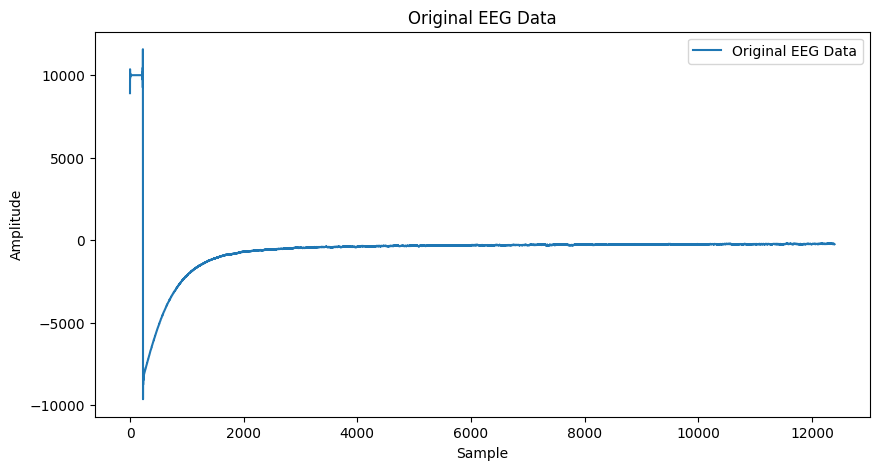

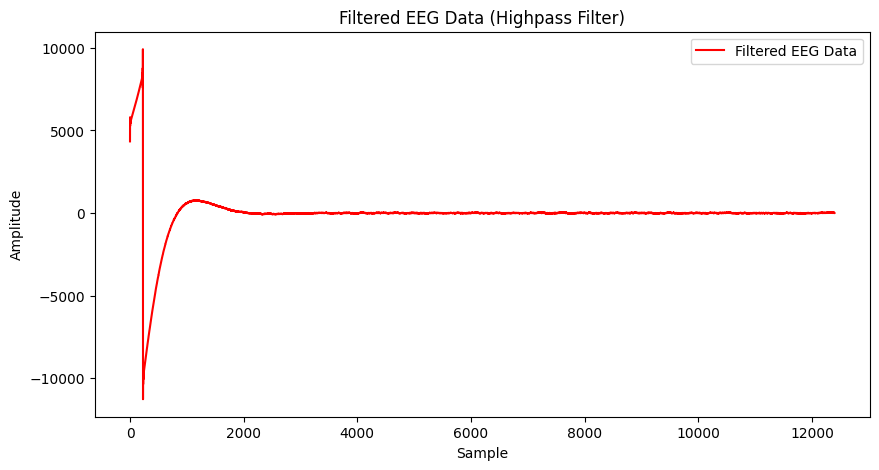

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Define function for applying highpass filter
def highpass_filter(data, cutoff_freq, fs):
    nyquist = 0.5 * fs
    cutoff = cutoff_freq / nyquist
    b, a = butter(2, cutoff, btype='high', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Read EEG data from the parquet file
eeg_id = 4294858825
fname = f'{paths.TRAIN_EEGS}{eeg_id}.parquet'
eeg = pd.read_parquet(fname)

# Display summary statistics of the EEG data
display(eeg.describe())

# Plot the original EEG data
plt.figure(figsize=(10, 5))
plt.plot(eeg.values.T[2, :], label='Original EEG Data')
plt.title('Original EEG Data')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Apply highpass filter with a cutoff frequency of 0.1 Hz
fs = 200  # Sample frequency in Hz
cutoff_freq = 0.1  # Cutoff frequency in Hz
filtered_data = highpass_filter(eeg.values.T[2, :], cutoff_freq, fs)

# Plot the filtered EEG data
plt.figure(figsize=(10, 5))
plt.plot(filtered_data, label='Filtered EEG Data', color='red')
plt.title('Filtered EEG Data (Highpass Filter)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


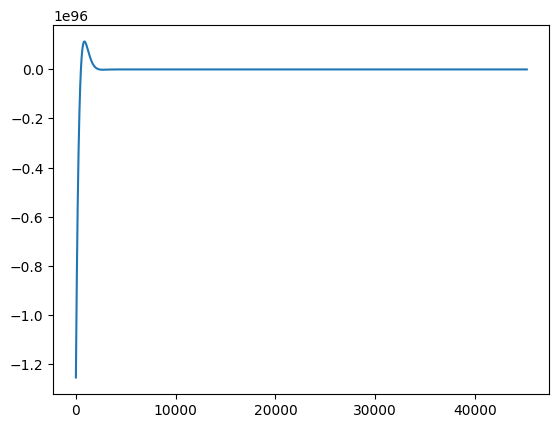

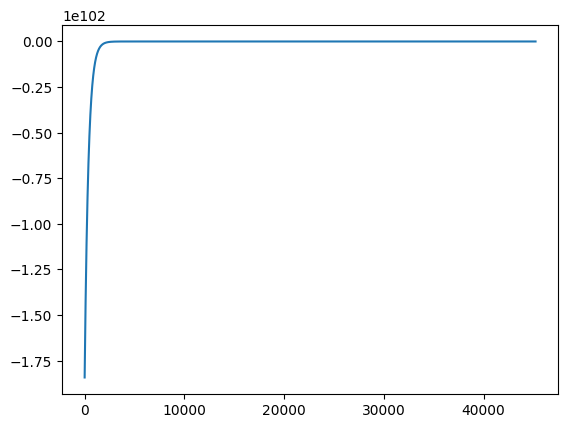

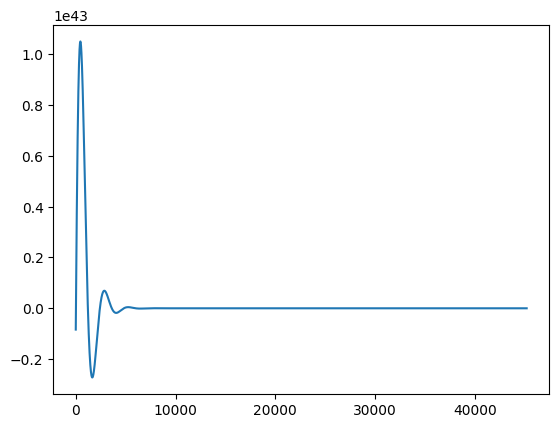

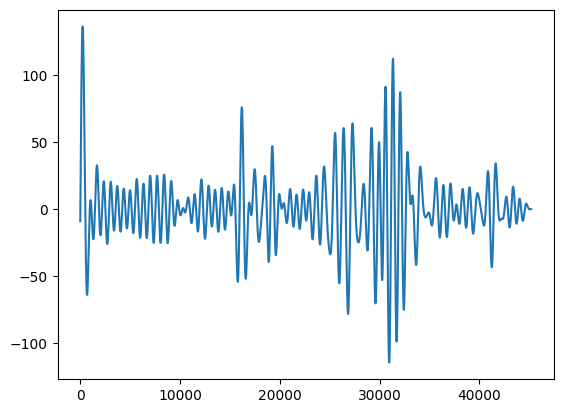

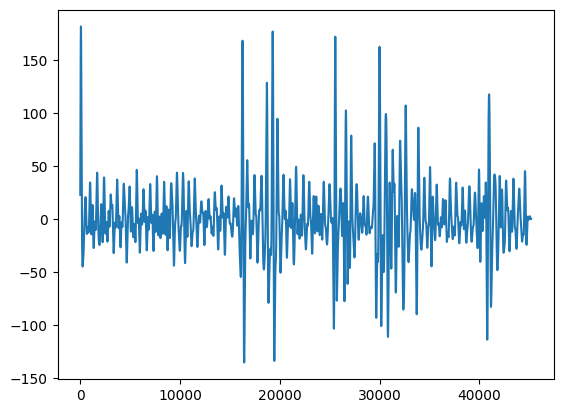

In [60]:
sampling_freq = 200

for band, (low_freq, high_freq) in frequency_ranges.items():
    result = apply_bandpass_filter(eeg, sampling_freq, low_freq, high_freq)
    
    plt.plot(result.T[0])
    plt.show()

## Extract Features

In [53]:
# Define the frequency bands
frequency_ranges = {'Delta': (0.1, 4),
                    'Theta': (4, 8),
                    'Alpha': (8, 12),
                    'Beta': (12, 30),
                    'Gamma': (30, 100)}

# Define the statistical feature functions
def calculate_mean(data):
    return np.mean(data)

def calculate_variance(data):
    return np.var(data)

def calculate_skewness(data):
    return skew(data, axis=(0,1))

def calculate_kurtosis(data):
    return kurtosis(data, axis=(0,1))

# Define a function to apply Butterworth bandpass filter
def apply_bandpass_filter(data, fs, lowcut, highcut, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], fs=fs, btype='band')
    return filtfilt(b, a, data, axis=0)

# Define a function to calculate wavelet features
def calculate_wavelet_features(data, wavelet='db6', level=9):
    coeffs = pywt.wavedec(data, wavelet, level=level, axis=0)
    
    wavelet_features = {'mean': [], 'variance': [], 'skewness': [], 'kurtosis': []}
    for coeff in coeffs:
        wavelet_features['mean'].append(calculate_mean(coeff))
        wavelet_features['variance'].append(calculate_variance(coeff))
        wavelet_features['skewness'].append(calculate_skewness(coeff))
        wavelet_features['kurtosis'].append(calculate_kurtosis(coeff))
    
    return wavelet_features

# Function to extract features from EEG segment
def extract_features(eeg_segment, sampling_freq):
    features = {}
    
    # Iterate over frequency bands
    for band, (low_freq, high_freq) in frequency_ranges.items():
        # Apply bandpass filter to extract data within frequency band
        filtered_data = apply_bandpass_filter(eeg_segment, sampling_freq, low_freq, high_freq)
        
        # Calculate statistical features for time domain
        features[f'{band}_mean_td'] = calculate_mean(filtered_data)
        features[f'{band}_variance_td'] = calculate_variance(filtered_data)
        features[f'{band}_skewness_td'] = calculate_skewness(filtered_data)
        features[f'{band}_kurtosis_td'] = calculate_kurtosis(filtered_data)
        
        # Calculate statistical features for frequency domain (using FFT)
        fft_data = np.abs(fft(filtered_data, axis=0))
        features[f'{band}_mean_fd'] = calculate_mean(fft_data)
        features[f'{band}_variance_fd'] = calculate_variance(fft_data)
        features[f'{band}_skewness_fd'] = calculate_skewness(fft_data)
        features[f'{band}_kurtosis_fd'] = calculate_kurtosis(fft_data)
        
        # Calculate statistical features for time-frequency domain (using wavelet transform)
        wavelet_features = calculate_wavelet_features(filtered_data)
        features[f'{band}_mean_tfd'] = np.mean(wavelet_features['mean'])
        features[f'{band}_variance_tfd'] = np.mean(wavelet_features['variance'])
        features[f'{band}_skewness_tfd'] = np.mean(wavelet_features['skewness'])
        features[f'{band}_kurtosis_tfd'] = np.mean(wavelet_features['kurtosis'])  
        
    return pd.DataFrame.from_dict(features, orient='index').T

# Example usage:
# eeg_segment = ...  # Extracted EEG segment
# sampling_freq = 200  # Sampling frequency of EEG data
# extracted_features_df = extract_features(eeg_segment, sampling_freq)
# print(extracted_features_df)


In [52]:
feature_dfs = []

for _, row in train_df.loc[:200].iterrows():
#     eeg_segment = extract_eeg_segment(example['eeg_id'], example['min'], example['max'])
    eeg_id = row['eeg_id']
    fname = f'{paths.TRAIN_EEGS}{eeg_id}.parquet'
    eeg = pd.read_parquet(fname)
    
    display(eeg.mean())
    
#     fs = 200
#     features = extract_features(eeg, fs)
#     feature_dfs.append(features)

# all_features_df = pd.concat(feature_dfs, ignore_index=True)

# display(all_features_df)

Fp1     -83.688431
F3      -70.744354
C3      -38.940079
P3      -39.293427
F7      -99.546005
T3      -39.795822
T5      -78.729050
O1      -46.548855
Fz      -18.649784
Cz      -32.257042
Pz      -45.045841
Fp2     -20.703747
F4      -26.628679
C4      -65.481140
P4      -29.564922
F8     -115.719391
T4        0.114058
T6      -39.974121
O2      -18.075434
EKG    2209.949951
dtype: float32

Fp1   -13.635587
F3     -8.120278
C3     -0.289290
P3     33.375889
F7     -9.953643
T3    -11.493170
T5    -11.689155
O1    -12.593448
Fz    -19.869169
Cz     -6.940027
Pz      4.913380
Fp2   -15.123873
F4    -18.559679
C4     13.890699
P4     -8.100312
F8    -22.561859
T4      1.978543
T6    -25.019514
O2    -16.780106
EKG    -8.443391
dtype: float32

Fp1   -10.407655
F3     15.022085
C3    -25.606096
P3    -14.088387
F7     -7.616158
T3    -33.549316
T5    -21.957800
O1    -28.040943
Fz     -0.548674
Cz     -2.575203
Pz    -14.508688
Fp2     2.545668
F4    -14.920165
C4    -29.257030
P4     -9.144072
F8     -3.953748
T4    -13.301147
T6    -15.180121
O2     23.224607
EKG    15.188473
dtype: float32

Fp1   -35.750599
F3    -16.929794
C3    -15.761327
P3      5.930231
F7    -14.829298
T3    -13.289709
T5      2.100284
O1     20.386438
Fz    -26.992563
Cz    -22.722670
Pz     -8.613610
Fp2   -12.648787
F4    -35.274918
C4    -37.060188
P4     -6.156617
F8    -13.391986
T4     -6.542239
T6    -14.850005
O2     -6.154692
EKG    -5.057926
dtype: float32

Fp1    20.348469
F3     -9.144577
C3    -32.882889
P3    -32.583248
F7     -0.388625
T3     -0.243760
T5     -7.960961
O1    -12.678929
Fz    -42.520214
Cz    -21.804932
Pz     49.440514
Fp2    97.459671
F4    -21.007481
C4     -5.008965
P4     17.098713
F8    -11.377578
T4    -68.996239
T6    -11.020391
O2    -32.158581
EKG    -4.847161
dtype: float32

Fp1    -8.672445
F3    -35.073605
C3     12.907788
P3      0.289622
F7    -27.845327
T3    -13.478485
T5    -30.320398
O1     -3.919186
Fz    -32.729786
Cz    -29.302803
Pz    -40.678318
Fp2    22.335602
F4     -2.738976
C4    -30.037916
P4    -25.697495
F8    -24.082251
T4    -15.483238
T6    -18.873716
O2    -23.570906
EKG   -10.237520
dtype: float32

Fp1   -119.796959
F3    -121.194572
C3    -117.554100
P3    -137.156296
F7    -137.219406
T3    -115.021347
T5    -119.889603
O1    -112.435898
Fz    -131.378845
Cz    -114.019562
Pz    -104.292648
Fp2   -119.016701
F4    -118.036575
C4    -134.987518
P4    -113.236626
F8    -116.817940
T4    -102.441216
T6    -134.356171
O2    -105.188698
EKG     21.146183
dtype: float32

Fp1   -15.409822
F3      1.863230
C3      4.167325
P3    -18.140289
F7    -16.217890
T3    -16.657421
T5      7.899083
O1    -36.456825
Fz    -10.084296
Cz    -33.811047
Pz     -8.969312
Fp2   -29.598827
F4    -12.491187
C4    -29.925528
P4    -23.234829
F8    -20.068357
T4    -40.191017
T6     -6.567658
O2    -10.420624
EKG   -14.828558
dtype: float32

Fp1    225.723175
F3     -50.098579
C3      -5.635075
P3      -1.410017
F7     -72.908203
T3      37.905399
T5     -56.854061
O1     -82.948509
Fz      26.552269
Cz      -9.401118
Pz      -1.319082
Fp2      8.453401
F4      26.685776
C4      -4.333216
P4       5.184309
F8       2.265748
T4      -1.713941
T6      11.047628
O2      -9.987308
EKG      8.985767
dtype: float32

Fp1    22.954210
F3    -16.796751
C3    -48.955658
P3    -30.089918
F7     -3.720566
T3    -22.951733
T5    -26.543175
O1     -4.258320
Fz     23.547018
Cz    -19.953154
Pz     13.167862
Fp2    -5.259447
F4     -7.619915
C4    -13.874512
P4    -28.045265
F8      0.716153
T4    -34.036850
T6    -29.032906
O2     18.405073
EKG    -8.572913
dtype: float32

Fp1    -9.455090
F3    -30.850849
C3    -13.111416
P3    -15.851440
F7     16.917135
T3     -9.158276
T5    -52.995678
O1    -11.642233
Fz     14.052101
Cz    -22.045259
Pz    -20.287140
Fp2    -1.581192
F4    -31.853416
C4     -4.993387
P4     13.625183
F8      8.041684
T4     -8.795545
T6      8.605119
O2     12.945561
EKG   -23.143642
dtype: float32

Fp1   -18.984816
F3    -10.184371
C3      2.658566
P3     20.663448
F7     -8.765588
T3    -16.681410
T5    -20.260359
O1    -69.298096
Fz    -14.795501
Cz    -10.625609
Pz    -31.848278
Fp2   -16.086466
F4    -19.341173
C4      2.360499
P4     26.996363
F8     -1.615033
T4     53.465828
T6    -36.676170
O2    -18.369961
EKG   -19.586071
dtype: float32

Fp1    -9.478984
F3    -16.110624
C3     -4.193763
P3      2.463544
F7     -3.194443
T3      3.204242
T5    -11.331368
O1    -10.284613
Fz     21.394165
Cz     -9.177324
Pz    -18.565979
Fp2    -3.313271
F4      1.186931
C4     18.834209
P4    -16.591307
F8     -9.371463
T4      3.681382
T6    -13.623737
O2    -19.660347
EKG   -12.957454
dtype: float32

Fp1   -16.667654
F3    -15.641552
C3    -39.005596
P3     -8.935786
F7    -26.635738
T3    -25.801815
T5     -9.309541
O1     -2.570109
Fz    -27.788109
Cz     -9.485920
Pz    -23.975775
Fp2    -3.385004
F4    -10.205265
C4    -50.081005
P4    -31.078291
F8    -17.708088
T4      9.456445
T6    -35.988312
O2    -12.218678
EKG    -9.773249
dtype: float32

Fp1   -11.142273
F3    -16.577099
C3    -11.063359
P3    -23.029413
F7    -19.091333
T3    -48.836498
T5    -20.254429
O1    -26.842834
Fz     -8.568296
Cz    -30.465244
Pz    -37.523815
Fp2   -22.147011
F4    -33.053272
C4     -9.458420
P4    -33.534874
F8      6.145517
T4    -37.662285
T6    -31.766796
O2    -22.711056
EKG    -3.465222
dtype: float32

Fp1   -47.263775
F3    -21.865463
C3      6.024076
P3    -12.117643
F7     13.612478
T3    -10.201191
T5    -21.663464
O1    -24.307014
Fz    -14.852472
Cz    -28.386387
Pz     -9.601100
Fp2   -15.160178
F4    -26.694881
C4    -21.239931
P4    -15.190767
F8    -43.916611
T4      1.785404
T6    -22.996677
O2     -7.670437
EKG   -27.827200
dtype: float32

Fp1     7.683954
F3      8.304446
C3     -2.014560
P3     -6.023701
F7     -4.358834
T3     -7.256850
T5      1.821068
O1      4.382478
Fz    -33.456150
Cz    -20.081615
Pz     -6.286791
Fp2     3.354985
F4     -1.659863
C4     -3.558332
P4    -17.615704
F8     -5.323378
T4     -4.229289
T6      6.385507
O2      7.381233
EKG    -8.228074
dtype: float32

Fp1    19.868090
F3    -17.475744
C3    -49.904537
P3    -29.539953
F7     -8.228168
T3    -23.494005
T5    -26.659048
O1     -3.311771
Fz     23.288063
Cz    -22.161673
Pz     14.935700
Fp2    -6.703242
F4    -10.129498
C4    -13.192262
P4    -28.834898
F8      0.618399
T4    -36.837261
T6    -27.115425
O2     18.428480
EKG   -12.968466
dtype: float32

Fp1    -13.541686
F3     -18.053255
C3     -19.427347
P3     -11.199051
F7     -38.818737
T3     -16.115675
T5     -28.155260
O1     -26.963678
Fz     -10.634704
Cz     -24.792767
Pz      11.335799
Fp2    -21.276033
F4      -3.978074
C4     -22.648144
P4     -19.107285
F8     -20.997509
T4     -11.845439
T6     -42.262806
O2     -92.082787
EKG    198.664062
dtype: float32

Fp1    -4.357672
F3    -10.435730
C3    -27.536741
P3    -21.148769
F7      3.947861
T3    -15.680857
T5     13.314697
O1    -32.735474
Fz    -12.608781
Cz    -30.561937
Pz    -26.650959
Fp2   -10.876934
F4    -27.020750
C4    -13.294903
P4     -2.335721
F8    -25.974310
T4    -25.602623
T6     15.323871
O2    -17.786459
EKG    -6.071345
dtype: float32

Fp1    -7.676634
F3    -31.500227
C3    -15.271708
P3    -30.861330
F7    -11.570545
T3    -27.784107
T5    -14.159122
O1    -27.725958
Fz     -3.066825
Cz      8.025126
Pz    -19.375525
Fp2   -28.031384
F4    -34.196342
C4    -10.394673
P4     26.307713
F8    -21.390902
T4    -32.227661
T6     -2.366400
O2    -16.852341
EKG     3.927128
dtype: float32

Fp1   -14.751540
F3     -9.854690
C3    -21.765409
P3    -21.705914
F7    -13.833950
T3      0.493243
T5    -12.746884
O1    -18.044525
Fz    -12.267201
Cz     -3.436151
Pz     -2.340523
Fp2    -4.923036
F4      4.548670
C4     -8.503839
P4     -8.668580
F8    -11.312189
T4     -7.878808
T6     -8.488084
O2    -23.669937
EKG   -21.854187
dtype: float32

Fp1   -155.468094
F3    -150.234299
C3    -145.268875
P3    -165.516800
F7    -170.994766
T3    -145.292831
T5    -154.115738
O1    -147.074692
Fz    -166.203232
Cz    -143.103622
Pz    -129.912384
Fp2   -161.111099
F4    -155.054520
C4    -170.107330
P4    -122.737923
F8    -156.896561
T4    -143.356812
T6    -171.903839
O2    -141.825989
EKG     22.090548
dtype: float32

Fp1    -5.751771
F3     -8.029449
C3     -2.893466
P3     33.737549
F7     -9.635790
T3     -8.436960
T5     -4.227524
O1    -11.274851
Fz    -19.212633
Cz     -8.533600
Pz      2.459091
Fp2   -12.035557
F4    -19.081068
C4     16.819027
P4     -9.195890
F8    -17.873405
T4      2.998345
T6    -23.094984
O2    -18.096119
EKG    -8.531916
dtype: float32

Fp1   -10.881866
F3      6.347588
C3     -0.627758
P3    -14.321140
F7    -10.754663
T3    -14.318763
T5     12.698352
O1    -34.223564
Fz     -4.250438
Cz    -30.988697
Pz     -6.250014
Fp2   -21.764465
F4     -8.711398
C4    -26.737268
P4    -20.749416
F8    -16.460829
T4    -36.973164
T6     -4.899923
O2     -9.528079
EKG   -22.199629
dtype: float32

Fp1   -49.443874
F3    -22.892817
C3    -36.682457
P3    -24.533607
F7    -22.270470
T3    -48.046478
T5    -13.801461
O1      6.007720
Fz     -8.009605
Cz     -5.492907
Pz    -10.721339
Fp2   -33.415504
F4    -11.309129
C4    -24.734354
P4    -28.200756
F8    -16.189157
T4     -0.774993
T6    -23.332899
O2      2.944892
EKG   -10.437245
dtype: float32

Fp1       1.415086
F3        0.927807
C3        0.287555
P3      -53.230164
F7        0.909091
T3        0.274665
T5        1.362116
O1       -4.492091
Fz        1.592439
Cz       -1.970730
Pz       -7.900516
Fp2       1.804568
F4        2.423856
C4        1.137124
P4       -4.392213
F8        3.152925
T4        2.225108
T6       -1.406955
O2       -1.986829
EKG    1100.464844
dtype: float32

Fp1     0.550049
F3    -19.311378
C3    -47.992577
P3    -38.960781
F7    -30.737478
T3    -31.255987
T5    -33.263664
O1     -0.787657
Fz     -6.260246
Cz      8.843834
Pz     -2.688456
Fp2     0.367646
F4     -9.741050
C4    -12.854061
P4    -12.800295
F8    -13.811392
T4      1.420595
T6     -4.206598
O2     -8.611310
EKG    18.191429
dtype: float32

Fp1   -0.601493
F3    -1.155504
C3    -1.288634
P3    -0.670736
F7    -1.531285
T3    -0.944440
T5    -0.576219
O1    -0.217565
Fz    -0.880814
Cz    -1.099975
Pz    -0.306120
Fp2    0.965029
F4    -0.576881
C4    -0.686136
P4    -0.756732
F8    -0.241035
T4    -1.242411
T6    -0.712777
O2    -0.644529
EKG   -1.208746
dtype: float32

Fp1     7.024800
F3    -26.122137
C3    -64.021248
P3    -45.205467
F7    -12.962646
T3    -44.078506
T5    -52.209225
O1    -20.578463
Fz     14.634450
Cz    -28.217243
Pz      0.744586
Fp2   -16.545891
F4    -17.522831
C4    -16.354713
P4    -44.011734
F8     -7.691194
T4    -42.971100
T6    -56.179028
O2     11.118596
EKG   -12.481752
dtype: float32

Fp1    -67.010750
F3       8.682795
C3     109.752754
P3      73.053123
F7     -13.199752
T3     -91.148445
T5     -21.917681
O1      41.377300
Fz     -63.806545
Cz     673.881042
Pz     128.378555
Fp2     51.410526
F4      -1.828863
C4     138.350128
P4     -45.543175
F8      22.212084
T4     763.555664
T6     -73.536079
O2     214.655258
EKG    -72.786743
dtype: float32

Fp1   -46.914757
F3    -18.257484
C3    -26.651224
P3    -22.247990
F7    -18.848232
T3    -13.248205
T5     -3.826241
O1      4.299413
Fz     -4.376558
Cz     -5.480536
Pz     -9.415342
Fp2   -23.260786
F4     -9.663191
C4    -23.930645
P4    -30.759012
F8    -14.486100
T4      0.350077
T6    -22.870762
O2      4.908462
EKG   -11.876023
dtype: float32

Fp1    11.813106
F3    -14.337820
C3    -44.608902
P3    -32.542362
F7    -30.646938
T3    -19.298401
T5    -27.480700
O1      2.638140
Fz     -5.746209
Cz      9.348177
Pz      5.872686
Fp2     6.178106
F4     -2.243106
C4     -7.484012
P4    -15.358726
F8     -7.136331
T4     12.634890
T6     -3.268524
O2     -6.981378
EKG    15.512882
dtype: float32

Fp1     0.559377
F3     -9.467492
C3     -9.390910
P3    -32.938297
F7     31.315733
T3    -30.091919
T5    -14.884635
O1     -7.582905
Fz     -1.792957
Cz     -4.820023
Pz      5.403186
Fp2     3.989005
F4    -16.602303
C4    -20.242689
P4      7.829745
F8     -6.386794
T4    -12.405750
T6    -31.871664
O2     -5.128048
EKG    11.815829
dtype: float32

Fp1     1.693674
F3    -28.367767
C3      7.359756
P3    -13.408666
F7    -27.684244
T3    -53.130573
T5    -10.815460
O1     22.557796
Fz    -20.043350
Cz      0.758966
Pz    -11.947062
Fp2   -14.360842
F4    -31.073368
C4    -15.505870
P4     -3.839081
F8    -33.719734
T4      0.314631
T6    -38.574055
O2     12.873691
EKG   -16.781822
dtype: float32

Fp1   -21.236538
F3    -12.404778
C3    -10.108815
P3     13.267143
F7     -6.514893
T3     -6.538029
T5      9.535062
O1     25.717569
Fz    -21.052233
Cz    -13.139503
Pz      1.007523
Fp2    -5.746446
F4    -29.173525
C4    -30.627834
P4      1.071738
F8     -7.597721
T4     -2.609944
T6     -7.793592
O2      2.357057
EKG    -5.559087
dtype: float32

Fp1   -12.789100
F3     -1.323892
C3    -13.737484
P3    -19.892790
F7    -53.728874
T3    -31.981844
T5      1.354424
O1     -9.817794
Fz    -28.855919
Cz    -14.501275
Pz    -12.156891
Fp2     9.044102
F4     -8.347693
C4     12.210728
P4      7.989453
F8    -35.105637
T4    -20.736609
T6    -23.128040
O2    -13.778854
EKG   -14.920939
dtype: float32

Fp1    -26.272545
F3     -34.286106
C3      -0.809227
P3      -8.649393
F7      -3.079207
T3       6.248192
T5     -25.040897
O1      -3.396009
Fz     -10.013185
Cz      17.807737
Pz      14.763391
Fp2     13.245712
F4      14.650178
C4     -15.075790
P4     -17.800186
F8     148.226746
T4      -5.216522
T6     -18.517767
O2       1.114857
EKG     11.096897
dtype: float32

Fp1     -4.381260
F3     114.921486
C3      24.236811
P3       3.458215
F7      63.862621
T3       0.598011
T5      18.272535
O1      22.382904
Fz      57.927284
Cz      24.983679
Pz     122.001457
Fp2    -15.195250
F4      12.136914
C4      15.185630
P4      24.037888
F8       8.007227
T4      -1.910287
T6     -16.885651
O2     -30.254011
EKG    127.099602
dtype: float32

Fp1     6.259121
F3     19.664316
C3    -22.348942
P3    -12.236409
F7      0.590350
T3    -29.585772
T5    -19.673647
O1    -27.216869
Fz      2.731558
Cz     -2.378502
Pz    -13.808647
Fp2    11.872775
F4    -10.729714
C4    -24.442543
P4     -9.313368
F8     -0.758596
T4    -10.971600
T6    -10.253311
O2     19.693701
EKG    13.764617
dtype: float32

Fp1     1.054153
F3     -4.578694
C3    -10.198539
P3     -9.689108
F7     -8.213815
T3    -36.687843
T5    -12.272533
O1    -20.209143
Fz      4.442039
Cz    -17.326414
Pz    -29.190006
Fp2    -8.753221
F4    -20.064970
C4      3.941477
P4    -22.508514
F8     19.554691
T4    -23.914614
T6    -20.131178
O2    -11.529333
EKG   -11.496977
dtype: float32

Fp1   -15.076059
F3    -31.446819
C3    -18.196535
P3    -22.077429
F7     22.136631
T3     -9.453273
T5    -47.577374
O1    -14.650647
Fz      5.644622
Cz    -22.878567
Pz    -24.262197
Fp2     2.224248
F4    -32.085342
C4     -8.782028
P4    -22.931866
F8      3.082255
T4     -9.552381
T6      2.344909
O2     11.060972
EKG   -35.217369
dtype: float32

Fp1   -31.663475
F3    -22.447247
C3    -20.081400
P3      0.423072
F7    -19.260717
T3    -16.894680
T5      0.209401
O1     16.321438
Fz    -33.112110
Cz    -26.956106
Pz     -9.901360
Fp2   -15.486278
F4    -39.536537
C4    -40.956043
P4     -9.366810
F8    -16.983540
T4    -13.758739
T6    -15.249472
O2     -6.842389
EKG    -5.582515
dtype: float32

Fp1   -27.889914
F3     -3.310907
C3     -2.169271
P3    -32.485519
F7      3.577054
T3      7.824562
T5      3.499172
O1    -15.368889
Fz     -3.184591
Cz     -1.255257
Pz     -1.972971
Fp2   -15.157769
F4    -13.239722
C4    -25.413363
P4     -6.258403
F8     -9.980506
T4     11.137403
T6    -24.240177
O2    -27.506636
EKG    -0.706606
dtype: float32

Fp1    -0.811699
F3     -7.381792
C3     -7.276964
P3    -30.749201
F7      2.729606
T3      2.792431
T5    -26.691090
O1    -12.446626
Fz    -20.016541
Cz    -21.439680
Pz    -11.182242
Fp2     2.618579
F4     -1.353555
C4     -4.529744
P4    -12.231277
F8      5.091751
T4    -17.691931
T6    -23.979536
O2    -17.816263
EKG   -13.523007
dtype: float32

Fp1   -32.019016
F3    -16.076206
C3    -28.403343
P3    -23.020578
F7     -4.679872
T3      3.345403
T5    -12.937416
O1    -19.884968
Fz    -29.257641
Cz     -1.771109
Pz    -25.608311
Fp2    22.728096
F4    -35.662575
C4     -5.488778
P4     -8.783646
F8     10.810693
T4      0.080522
T6     -7.372004
O2    -15.759409
EKG    -2.952948
dtype: float32

Fp1      -4.993004
F3       -0.533108
C3       -0.540316
P3       -0.647920
F7       -0.156001
T3        0.872185
T5        0.260205
O1        0.097458
Fz       -1.405537
Cz       -1.432177
Pz       -0.729824
Fp2      -6.784119
F4       -1.944064
C4       -0.876417
P4       -0.682220
F8        0.578091
T4       -0.109038
T6        0.475269
O2        0.236325
EKG    2765.690918
dtype: float32

Fp1   -24.540977
F3    -17.006990
C3    -14.834442
P3      5.938312
F7    -11.029944
T3    -11.529265
T5      3.524804
O1     23.910830
Fz    -26.165482
Cz    -19.478899
Pz     -3.383449
Fp2    -9.540518
F4    -29.376373
C4    -35.022442
P4     -2.169860
F8     -8.694639
T4     -5.000078
T6     -9.403235
O2     -1.437424
EKG    -4.001210
dtype: float32

Fp1     1.737487
F3    -16.372257
C3    -13.359934
P3    -25.933664
F7     -9.472190
T3    -26.236097
T5    -11.414164
O1    -21.854393
Fz     -0.207237
Cz     12.272995
Pz    -18.218029
Fp2    -9.064966
F4    -17.393593
C4     10.359890
P4      2.734675
F8    -16.706951
T4    -39.294014
T6     -2.921330
O2    -19.192825
EKG   -21.766962
dtype: float32

Fp1    16.912050
F3    -15.820997
C3     -9.328387
P3     -8.910011
F7    -13.261474
T3    -35.216003
T5     15.434397
O1     52.885208
Fz    -31.123203
Cz     18.284124
Pz     54.622002
Fp2   -15.352921
F4     -5.081216
C4    -65.079010
P4    -79.185959
F8     -9.917056
T4    -12.130364
T6    -41.123390
O2     33.759136
EKG    18.125015
dtype: float32

Fp1     1.030209
F3    -28.332222
C3     -2.073791
P3    -16.526749
F7    -20.129921
T3    -15.280869
T5    -25.618738
O1    -17.564333
Fz    -20.135654
Cz     -7.768006
Pz    -27.541035
Fp2   -22.346321
F4    -15.891063
C4     -8.694267
P4    -19.846710
F8    -33.977406
T4    -10.637250
T6    -23.102772
O2     -8.088967
EKG    20.172371
dtype: float32

Fp1    4.105027
F3     1.762643
C3     2.139862
P3     0.320817
F7     3.219294
T3     1.261438
T5     1.956841
O1     0.772378
Fz     1.103780
Cz     1.111867
Pz     2.270281
Fp2    2.319428
F4     0.042459
C4     0.584987
P4     1.397193
F8    -1.293024
T4    -1.562924
T6    -0.287114
O2     5.919608
EKG   -4.181730
dtype: float32

Fp1   -35.161751
F3    -39.286423
C3     -1.196369
P3    -23.952353
F7    -47.274311
T3    -31.722809
T5     -8.278706
O1    -47.191849
Fz    -53.773666
Cz    -43.369640
Pz    -25.245274
Fp2   -39.086090
F4    -63.188400
C4    -52.732033
P4    -31.869339
F8    -22.822119
T4    -44.389709
T6    -47.933949
O2    -42.183250
EKG     0.144578
dtype: float32

Fp1    4.834083
F3     3.282447
C3     2.016095
P3     2.177152
F7     3.670923
T3     4.963177
T5     3.305299
O1     2.425655
Fz     1.254265
Cz     1.398086
Pz     1.443917
Fp2    2.570238
F4     1.802790
C4     1.407205
P4     1.371084
F8     1.766880
T4     2.264860
T6     2.300068
O2     2.293081
EKG    3.817279
dtype: float32

Fp1   -10.027865
F3    -54.534340
C3     17.442327
P3     37.756191
F7    -40.264912
T3     -3.940096
T5    -28.663296
O1     15.434231
Fz      9.763058
Cz     17.896744
Pz     -7.060246
Fp2    29.473211
F4     35.587292
C4      3.942729
P4    -46.251862
F8      8.880965
T4     12.441746
T6     -1.447914
O2     21.276340
EKG    28.188667
dtype: float32

Fp1   -40.118675
F3    -50.889126
C3    -17.132425
P3    -23.286484
F7    -37.465210
T3     -5.479291
T5    -32.467369
O1    -20.389269
Fz    -29.423893
Cz     -1.577089
Pz     -3.186237
Fp2    -5.325647
F4     -6.105005
C4    -31.915474
P4    -38.042637
F8    -29.611610
T4    -28.464882
T6    -37.896870
O2     -9.922542
EKG     3.138599
dtype: float32

Fp1   -26.009117
F3     -6.702187
C3      4.011244
P3     -7.970117
F7    -28.611866
T3    -35.408897
T5     26.154015
O1     53.295586
Fz     35.312233
Cz      9.261580
Pz      4.173185
Fp2    21.381811
F4    -23.086159
C4     33.710567
P4    -41.535118
F8     -3.162677
T4    -26.683441
T6    -91.208084
O2    -13.641993
EKG     2.121627
dtype: float32

Fp1    -7.434915
F3    -20.301651
C3    -18.786839
P3    -11.482874
F7     -7.218946
T3     -1.723449
T5     11.792460
O1     -6.234431
Fz      8.340982
Cz     -8.900601
Pz    -21.663630
Fp2   -13.021986
F4      5.627274
C4    -14.586141
P4    -22.907598
F8      7.688270
T4     -9.794843
T6    -14.562038
O2    -19.104191
EKG   -36.401134
dtype: float32

Fp1   -18.978411
F3    -38.538433
C3    -28.379959
P3    -40.383595
F7    -51.136826
T3    -35.071945
T5    -17.438145
O1    -25.985670
Fz    -46.666080
Cz    -57.946774
Pz    -17.909891
Fp2   -14.951597
F4    -19.552599
C4    -30.011959
P4    -10.930828
F8    -46.038506
T4    -24.867693
T6    -33.759598
O2     -5.445755
EKG    18.838297
dtype: float32

Fp1   -22.705004
F3    -23.181004
C3     -2.623567
P3      4.647462
F7     -7.616792
T3     -4.391095
T5    -10.724055
O1     11.003880
Fz     -7.980932
Cz      7.405114
Pz    -13.259552
Fp2     6.561385
F4    -17.262362
C4    -21.082077
P4     -2.888386
F8     14.329719
T4      6.994769
T6     -1.541891
O2     -4.677344
EKG    -4.562147
dtype: float32

Fp1    18.657001
F3    -26.263525
C3    -34.066673
P3      1.648906
F7      6.040028
T3      9.246762
T5      2.398983
O1     -4.290361
Fz    -17.113375
Cz     11.109097
Pz     -5.497739
Fp2    -5.530311
F4      2.446738
C4     11.035761
P4      1.239104
F8    -15.473761
T4      9.105597
T6     -8.923045
O2      0.123323
EKG   -48.747612
dtype: float32

Fp1    -9.832396
F3    -21.952448
C3    -17.484346
P3    -20.844852
F7     17.418037
T3    -13.800546
T5    -51.542519
O1    -15.377389
Fz      5.061111
Cz    -20.317516
Pz    -27.375669
Fp2    -4.437440
F4    -34.785984
C4     -6.713481
P4    -19.951418
F8     -0.075856
T4    -13.460865
T6     -2.842275
O2      8.312055
EKG   -23.475679
dtype: float32

Fp1    -2.517663
F3     -9.713774
C3    -16.692062
P3      9.764807
F7    -34.522812
T3    -10.666985
T5    -22.479525
O1    -25.028259
Fz     -2.745962
Cz    -45.192970
Pz     39.621262
Fp2   -10.425734
F4     -1.790499
C4    -22.178665
P4    -13.013341
F8    -19.281359
T4    -20.894711
T6    -42.956375
O2     -2.092386
EKG    -4.281806
dtype: float32

Fp1   -45.495731
F3    -15.865057
C3    -25.523708
P3    -22.749083
F7    -18.498079
T3    -16.403881
T5     -9.893405
O1      1.181503
Fz     -6.748427
Cz     -7.873997
Pz     -8.918755
Fp2   -22.581495
F4     -8.415421
C4    -25.136835
P4    -30.838558
F8    -11.310923
T4      3.149851
T6    -28.535322
O2      3.278911
EKG   -12.468231
dtype: float32

Fp1   -38.460987
F3    -24.729288
C3    -13.104878
P3     -8.538054
F7    -23.990988
T3    -12.803780
T5    -17.308575
O1     -5.973444
Fz    -29.742699
Cz    -32.705853
Pz      2.417046
Fp2   -24.646135
F4     -6.381124
C4    -27.257946
P4    -25.569168
F8    -23.006115
T4     -9.851508
T6    -13.530767
O2     -2.798501
EKG     2.698234
dtype: float32

Fp1    -87.083099
F3    -109.997368
C3     -73.978851
P3    -100.122276
F7     -90.662483
T3    -100.319199
T5    -100.259636
O1     -93.577415
Fz    -109.559830
Cz     -92.384033
Pz    -103.238205
Fp2   -117.116997
F4    -102.319794
C4     -91.507118
P4     -99.699554
F8    -124.503891
T4    -101.491814
T6    -113.562309
O2     -96.964951
EKG     26.342583
dtype: float32

Fp1     2.980318
F3    -15.890376
C3    -43.892380
P3    -32.028339
F7    -30.639505
T3    -22.633087
T5    -24.282438
O1      5.007154
Fz     -5.274333
Cz     12.334422
Pz      8.611082
Fp2     6.115265
F4     -0.945197
C4     -5.516434
P4    -10.554672
F8     -7.700769
T4     13.441046
T6     -1.609837
O2      3.420856
EKG    30.831219
dtype: float32

Fp1   -22.816765
F3    -34.945423
C3    -15.033987
P3     -8.177806
F7    -54.125187
T3    -37.658463
T5    -47.019344
O1    -42.091190
Fz    -14.053972
Cz    -23.599890
Pz      9.994188
Fp2   -32.183067
F4     -4.919315
C4    -20.194710
P4    -15.583844
F8    -20.803802
T4    -11.255017
T6    -43.117710
O2     -3.373664
EKG    -3.705744
dtype: float32

Fp1     8.041532
F3    -19.969645
C3    -48.363392
P3    -29.502615
F7     -5.280789
T3    -16.588903
T5    -23.009310
O1     -2.584443
Fz     23.294832
Cz    -17.649111
Pz     15.998840
Fp2   -23.245911
F4    -12.865390
C4    -14.032941
P4    -25.066645
F8     -2.368821
T4    -34.676033
T6    -29.379082
O2     20.425158
EKG   -12.800223
dtype: float32

Fp1   -42.159161
F3    -27.911465
C3    -40.485748
P3    -47.170879
F7    -81.867340
T3    -59.023632
T5    -25.465416
O1    -35.250977
Fz    -55.716114
Cz    -43.003819
Pz    -44.238327
Fp2   -18.554525
F4    -35.606186
C4    -12.583189
P4    -18.756804
F8    -65.540695
T4    -46.754662
T6    -50.547333
O2    -37.511597
EKG   -13.917364
dtype: float32

Fp1   -14.624300
F3    -14.504256
C3    -20.195415
P3    -14.048235
F7     -8.152267
T3    -20.555470
T5     -6.681620
O1      4.445769
Fz     15.319566
Cz    -38.660027
Pz     -8.616522
Fp2    -2.434908
F4     13.736863
C4    -13.561502
P4    -11.036391
F8     -2.668581
T4     -5.215188
T6      0.038676
O2    -32.238548
EKG     3.980372
dtype: float32

Fp1    -1.815338
F3     -5.438952
C3     -8.733149
P3     -5.794681
F7      0.424692
T3     -7.654546
T5      8.956158
O1     -7.672078
Fz     -1.869305
Cz     -0.294994
Pz     -4.416884
Fp2   -11.985978
F4      1.880620
C4    -19.523088
P4    -20.082691
F8    -18.247629
T4      8.466949
T6    -25.782228
O2    -12.563194
EKG    17.414135
dtype: float32

Fp1    14.135732
F3      0.403661
C3     -0.062420
P3      0.011512
F7      0.485228
T3      0.077900
T5      0.042439
O1      0.110806
Fz      0.037628
Cz      0.043202
Pz      0.129612
Fp2    -0.266549
F4     -0.192289
C4     -0.146272
P4     -0.315308
F8     -0.701642
T4     -0.268224
T6     -0.039588
O2      0.210646
EKG    -0.358549
dtype: float32

Fp1    25.783451
F3     56.641220
C3      8.257047
P3     35.028809
F7     64.398369
T3     52.967075
T5      6.109863
O1     26.867676
Fz     28.801577
Cz     15.117618
Pz     49.715015
Fp2    50.624340
F4     65.787010
C4     60.578777
P4     28.813639
F8     21.408615
T4     82.679878
T6     59.763008
O2     20.271540
EKG   -55.067303
dtype: float32

Fp1     1.863518
F3      3.214136
C3    -46.537731
P3    -15.432573
F7      0.201166
T3    -42.090664
T5     -0.582561
O1    -32.076817
Fz     29.378090
Cz     39.662354
Pz    -14.633950
Fp2   -14.783113
F4    -11.011558
C4     12.765294
P4     -7.552169
F8    -22.800545
T4     -4.618886
T6    -18.565115
O2    -14.144886
EKG   -26.141647
dtype: float32

Fp1   -13.509341
F3     -7.477949
C3    -24.224115
P3    -17.779423
F7     -8.281155
T3    -13.145201
T5    -12.618347
O1    -23.567581
Fz    -26.858141
Cz     -8.416201
Pz    -18.604015
Fp2    -4.479907
F4    -17.214012
C4    -13.464960
P4     -9.891249
F8    -30.497690
T4    -11.022144
T6     -9.832078
O2    -16.109396
EKG     2.501436
dtype: float32

Fp1   -3.259662
F3    -3.732253
C3    -6.226834
P3    -4.017679
F7    -4.038560
T3    -3.824612
T5    -1.511028
O1    -4.028682
Fz    -4.020673
Cz    -4.615788
Pz    -3.578872
Fp2   -5.853185
F4    -3.801771
C4    -3.410665
P4    -3.904412
F8    -3.585351
T4    -3.723047
T6    -4.118825
O2    -3.355053
EKG    5.366962
dtype: float32

Fp1    24.583857
F3     63.556820
C3     24.585419
P3     38.041386
F7     42.880657
T3     16.962013
T5     24.729656
O1     26.359438
Fz     53.328068
Cz     49.382694
Pz     39.737358
Fp2    42.556114
F4     37.981197
C4     23.532101
P4     40.288471
F8     51.251217
T4     40.707005
T6     14.822863
O2     78.614914
EKG    15.486149
dtype: float32

Fp1    31.763010
F3     60.599045
C3     30.211288
P3     82.473190
F7     74.119202
T3     67.362213
T5     83.235550
O1     69.181290
Fz    -20.286934
Cz     35.311844
Pz     74.342453
Fp2    56.824711
F4     84.367554
C4     68.786659
P4     51.372276
F8     37.592323
T4     86.096184
T6     80.186134
O2     84.621979
EKG    29.031254
dtype: float32

Fp1   -19.466600
F3    -15.773547
C3    -29.751406
P3    -32.165508
F7    -19.604460
T3     -8.714998
T5    -20.488918
O1    -26.078339
Fz    -14.968335
Cz    -10.804386
Pz    -12.938329
Fp2   -12.980057
F4     -2.434372
C4    -17.525070
P4    -18.988354
F8    -15.431188
T4    -15.365359
T6    -16.452660
O2    -32.915508
EKG   -21.736269
dtype: float32

Fp1    -7.731109
F3      2.289441
C3    -45.859608
P3    -17.556803
F7     -1.693217
T3    -40.526646
T5     -8.096625
O1    -32.324402
Fz     11.034396
Cz     -2.001401
Pz     -9.329985
Fp2   -13.189341
F4    -14.596112
C4     -7.334706
P4     -1.758545
F8    -21.648289
T4    -20.243917
T6    -13.308636
O2    -14.927647
EKG   -15.589149
dtype: float32

Fp1    -24.485813
F3    -369.926758
C3     -37.298630
P3     -69.197121
F7      17.200399
T3     -27.537424
T5      18.118351
O1     111.421341
Fz     -45.416958
Cz      11.441039
Pz     -50.595810
Fp2    -19.495674
F4     -28.158216
C4     -11.820984
P4     -35.981598
F8     -33.081989
T4     -30.794310
T6      34.059345
O2      22.088358
EKG      3.361616
dtype: float32

Fp1   -118.083305
F3    -120.438667
C3    -119.594032
P3    -139.085083
F7    -138.598358
T3    -110.651634
T5    -121.427460
O1    -112.571518
Fz    -133.782364
Cz    -113.971107
Pz    -102.411606
Fp2   -118.339226
F4    -118.712273
C4    -134.305511
P4    -117.678558
F8    -115.533127
T4     -98.474762
T6    -133.095688
O2    -105.579277
EKG     15.307686
dtype: float32

Fp1    153.562698
F3     166.502090
C3     143.784210
P3     139.744583
F7     150.931259
T3     133.616928
T5     140.045410
O1     152.678497
Fz     111.196060
Cz     137.934006
Pz     143.129608
Fp2    157.649445
F4     125.572281
C4     148.655716
P4     112.948532
F8     141.981354
T4     134.167313
T6     157.083282
O2     154.121368
EKG     -6.582442
dtype: float32

Fp1     3.292227
F3     -0.314439
C3     10.585743
P3     -7.558836
F7     -2.488614
T3    -25.171244
T5     -3.917593
O1    -13.843233
Fz     -1.042610
Cz    -12.067730
Pz    -24.562325
Fp2    -3.111820
F4     -2.705911
C4     15.063741
P4     25.303835
F8     28.514498
T4    -13.107463
T6      2.926612
O2      4.868552
EKG   -11.486451
dtype: float32

Fp1   -29.472500
F3    -37.164848
C3     -3.825653
P3    -14.022359
F7    -24.619408
T3      2.934990
T5    -23.934013
O1    -10.828853
Fz    -14.130911
Cz     10.934439
Pz      7.452246
Fp2     9.147703
F4     11.144673
C4    -20.453363
P4     14.536141
F8    -12.953928
T4    -18.276636
T6    -22.509756
O2     -0.818828
EKG     2.332064
dtype: float32

Fp1     5.588648
F3     -6.808181
C3     23.617504
P3     -1.025150
F7      6.503232
T3     -6.810874
T5      4.417214
O1    -18.431158
Fz    -17.031263
Cz    -14.867178
Pz    -13.535256
Fp2   -11.715668
F4    -24.679428
C4     -0.908057
P4     -7.174522
F8    -24.820560
T4    -27.281109
T6    -12.619573
O2    -27.399597
EKG    10.013558
dtype: float32

Fp1    73.711182
F3     37.294315
C3     51.016090
P3     58.320919
F7     58.354885
T3     57.566246
T5     39.668434
O1     50.569565
Fz     73.139641
Cz     51.496628
Pz     39.104465
Fp2    40.894444
F4     54.691002
C4     68.218643
P4    -47.579945
F8     33.796379
T4     53.247910
T6     52.612045
O2    -19.155632
EKG   -10.549371
dtype: float32

Fp1   -12.835690
F3    -17.320753
C3    -36.794399
P3     -8.403168
F7    -10.514310
T3    -20.788052
T5    -37.899384
O1    -26.999363
Fz    -17.917841
Cz     -6.505295
Pz    -20.843222
Fp2    -0.749223
F4     -8.315948
C4    -43.665447
P4    -21.100355
F8     -8.913564
T4     15.034301
T6    -25.247614
O2      3.130933
EKG    -4.034697
dtype: float32

Fp1    19.283846
F3      4.852659
C3    -45.296368
P3    -16.065268
F7      1.079150
T3    -39.833683
T5     -2.118421
O1    -26.609354
Fz     31.341162
Cz     41.401333
Pz     -5.909334
Fp2    50.076107
F4     -7.448193
C4     11.729516
P4     -4.818491
F8    -20.971266
T4    -17.953194
T6    -16.253988
O2    -12.228086
EKG   -32.071243
dtype: float32

Fp1   -0.765355
F3    -1.847575
C3    -1.286722
P3    -0.325665
F7     0.267543
T3     0.105394
T5     1.509355
O1    -0.129232
Fz    -0.726629
Cz    -1.307534
Pz    -1.263143
Fp2   -0.158709
F4    -1.044012
C4    -1.024875
P4    -0.604640
F8    -1.196751
T4    -0.027334
T6     0.249659
O2     0.781875
EKG   -0.296938
dtype: float32

Fp1     -6.991628
F3      47.818565
C3     -38.118813
P3      -0.129651
F7       9.831586
T3     -15.550286
T5     -19.799068
O1     -13.986334
Fz     -33.825752
Cz       0.543354
Pz      17.405270
Fp2    -17.535704
F4    -304.854736
C4     -10.224930
P4       7.576540
F8      13.514674
T4      93.363319
T6      23.842791
O2      -9.319859
EKG     -5.692676
dtype: float32

Fp1   -28.410889
F3    -16.528175
C3      1.739055
P3    -10.470794
F7     11.807137
T3    -10.293090
T5    -18.897511
O1    -21.926336
Fz    -12.203923
Cz    -27.717161
Pz     -6.960700
Fp2    -9.519138
F4    -24.498314
C4    -29.560257
P4    -15.374462
F8    -37.449398
T4      1.396780
T6    -25.878256
O2     -7.475435
EKG   -26.653000
dtype: float32

Fp1    114.874565
F3     145.057968
C3     157.097580
P3     173.255798
F7     226.459106
T3     209.638931
T5     209.492569
O1     164.136169
Fz     151.309921
Cz     154.844055
Pz     142.015289
Fp2     48.253696
F4     113.214996
C4     159.850632
P4     176.137085
F8      38.888073
T4     151.459595
T6     185.576233
O2     143.608643
EKG    -17.973972
dtype: float32

Fp1     3.034418
F3    -10.136825
C3    -10.835299
P3    -33.688423
F7     51.027283
T3    -31.880188
T5    -14.517293
O1     -7.990470
Fz     -3.371512
Cz     -6.637639
Pz      3.480758
Fp2     0.817854
F4    -17.307123
C4    -23.013124
P4     10.343360
F8     -7.313237
T4    -11.730649
T6    -30.022207
O2     -2.335008
EKG    -8.943816
dtype: float32

Fp1   -16.659330
F3    -10.405333
C3    -24.675175
P3    -25.618477
F7    -15.433539
T3      0.234377
T5    -16.141714
O1    -19.445934
Fz    -13.245269
Cz     -5.869663
Pz     -4.941672
Fp2    -6.761487
F4      4.164249
C4    -11.382372
P4    -11.186982
F8    -13.380110
T4     -7.673740
T6     -9.656588
O2    -25.559446
EKG   -21.392628
dtype: float32

Fp1   -15.253828
F3    -13.440972
C3    -23.515234
P3    -25.785192
F7    -13.514778
T3     -9.318600
T5     -9.842213
O1    -17.876781
Fz    -26.284794
Cz    -11.696694
Pz     -2.658732
Fp2   -10.429502
F4     -2.366841
C4    -12.043157
P4    -13.475912
F8    -13.015989
T4     -9.716175
T6     -8.342227
O2    -27.511997
EKG     5.201280
dtype: float32

Fp1     1.762381
F3      4.324024
C3      0.383483
P3    -28.550756
F7     10.915405
T3     14.930387
T5    -29.385233
O1      9.103099
Fz     -8.563219
Cz     -9.946725
Pz     -1.526914
Fp2     6.941805
F4      3.412420
C4      7.800745
P4      8.039841
F8      5.873513
T4    -15.156528
T6    -16.921110
O2     -7.075355
EKG   -12.181555
dtype: float32

Fp1    -34.041279
F3     -63.538750
C3    -181.843491
P3     -50.846260
F7     -83.138382
T3     -95.022713
T5      -6.947063
O1     -29.362785
Fz     -76.521210
Cz     -82.855499
Pz     -35.135136
Fp2    -41.896427
F4     -42.898170
C4     -45.364933
P4     -14.733783
F8     -62.845348
T4     -31.277161
T6     -29.318144
O2       8.811596
EKG     39.562519
dtype: float32

Fp1    -2.911353
F3    -11.517970
C3     -6.667861
P3     -1.146615
F7     -7.658821
T3      0.561593
T5      4.764843
O1    -16.809431
Fz    -21.420706
Cz      9.542927
Pz    -23.206696
Fp2    14.954060
F4     -9.233351
C4     14.933455
P4    -24.239241
F8    -31.724470
T4    -37.464958
T6    -25.256258
O2     -1.518644
EKG   -16.600555
dtype: float32

Fp1     8.494860
F3    -12.564233
C3      3.936238
P3      1.705442
F7    -20.396019
T3     -7.573183
T5    -12.759890
O1    -17.988031
Fz      4.614649
Cz     12.186997
Pz     -1.351424
Fp2   -15.489669
F4     -2.743752
C4    -16.737013
P4    -13.205233
F8      4.837420
T4    -19.246101
T6    -15.343539
O2     -9.890293
EKG   -12.876033
dtype: float32

Fp1     62.131645
F3      20.778395
C3      79.670654
P3      54.460548
F7      70.344170
T3      82.494308
T5      45.880524
O1       9.622796
Fz      54.232388
Cz      70.037979
Pz      73.201920
Fp2     45.415237
F4      57.489403
C4      61.675243
P4      50.893135
F8      28.269133
T4      59.681713
T6       5.882376
O2     -44.685814
EKG    159.815674
dtype: float32

Fp1   -20.490177
F3    -37.121620
C3    -21.810972
P3    -25.034456
F7     14.102757
T3    -13.665971
T5    -53.056454
O1    -17.294943
Fz      1.949046
Cz    -26.561443
Pz    -24.467480
Fp2    -2.274812
F4    -36.019009
C4    -10.273320
P4    -25.965075
F8      1.801779
T4    -14.847537
T6     -1.746354
O2      5.426516
EKG   -34.819111
dtype: float32

Fp1    19.034374
F3     33.468559
C3      0.902720
P3    -10.240091
F7      3.520262
T3    -12.511848
T5     -0.812901
O1    -14.118007
Fz      9.222575
Cz     23.176937
Pz     -8.228646
Fp2   -12.418411
F4    -17.519722
C4      2.430512
P4     12.557972
F8     -4.400503
T4    -29.599199
T6     17.921335
O2     -5.515936
EKG     4.453044
dtype: float32

Fp1     3.727473
F3    -16.087351
C3    -27.440491
P3    -15.714993
F7      4.866790
T3    -11.343760
T5      0.026075
O1     -5.272418
Fz    -25.693783
Cz    -37.415550
Pz      3.075468
Fp2     6.435031
F4      0.226817
C4     -6.720764
P4     10.233780
F8    -19.554777
T4      2.393964
T6     -8.990898
O2     13.980703
EKG    17.938253
dtype: float32

Fp1    13063.778320
F3     11181.160156
C3     10642.857422
P3     11533.781250
F7     11607.107422
T3     11611.328125
T5     10768.386719
O1     10568.718750
Fz       -30.201237
Cz       -12.956011
Pz       -18.344906
Fp2    11080.716797
F4     11619.794922
C4     12013.422852
P4     11416.247070
F8     11313.924805
T4     11587.553711
T6     11235.099609
O2     10878.952148
EKG     -269.862488
dtype: float32

Fp1   -21.563705
F3      8.152853
C3     -6.270146
P3      3.254961
F7    -12.070957
T3     -9.608983
T5    -10.654258
O1     -5.208204
Fz    -10.895489
Cz      5.030235
Pz      6.143167
Fp2     0.152526
F4     12.809946
C4     -9.723392
P4     15.287043
F8     -7.467231
T4      0.079158
T6     -8.726485
O2     11.319153
EKG    12.787271
dtype: float32

Fp1   -24.835238
F3     -7.928672
C3    -21.152651
P3    -29.511559
F7    -61.112709
T3    -41.048019
T5     -6.247121
O1     -7.778776
Fz    -34.806469
Cz    -24.199266
Pz    -25.291647
Fp2    -0.892818
F4    -13.696320
C4     11.894291
P4      0.939711
F8    -44.429943
T4    -16.512619
T6    -27.989822
O2     25.897472
EKG   -21.546356
dtype: float32

Fp1   -14.490254
F3    -33.238300
C3    -25.335804
P3    -30.988979
F7     -9.552311
T3     -7.684145
T5    -30.342167
O1    -21.708395
Fz    -19.435606
Cz      9.867471
Pz    -14.346717
Fp2   -29.215733
F4    -14.081234
C4    -24.038115
P4    -31.941107
F8    -40.646214
T4      5.674551
T6    -11.112291
O2    -23.658428
EKG    33.156857
dtype: float32

Fp1     1.766107
F3    -33.684837
C3    -44.382141
P3    -45.418320
F7    -32.153843
T3    -21.501614
T5    -26.843863
O1      6.156006
Fz     -3.279123
Cz      9.093819
Pz     -8.207963
Fp2     5.000054
F4    -21.621359
C4     -3.737877
P4     -1.663435
F8    -10.990577
T4     14.898986
T6     -4.879733
O2    -10.994117
EKG    19.167854
dtype: float32

Fp1    -6.043513
F3     -0.799913
C3      5.099995
P3     35.946758
F7     -7.560250
T3     -9.445860
T5     -7.808125
O1    -11.109372
Fz    -15.333755
Cz     -2.096844
Pz      9.332532
Fp2    -9.725099
F4    -14.099289
C4     16.831676
P4     -4.886817
F8    -16.908300
T4      5.207782
T6    -20.215055
O2    -16.398073
EKG    -7.160109
dtype: float32

Fp1     2.771377
F3      2.562899
C3      3.390031
P3      7.712289
F7      2.994855
T3      3.411428
T5     18.899378
O1      5.617391
Fz     73.598564
Cz      3.205185
Pz      3.075983
Fp2     3.014970
F4      2.443671
C4      3.078937
P4      2.127613
F8      3.412767
T4      4.246573
T6      3.436862
O2      3.537032
EKG   -19.276421
dtype: float32

Fp1    16.640181
F3      9.035024
C3      7.447535
P3    -11.747617
F7     16.326080
T3    -11.295575
T5     13.984319
O1    -33.138725
Fz     25.831444
Cz      3.824983
Pz     21.016769
Fp2     4.100105
F4     -4.312499
C4    -24.178013
P4    -16.564304
F8    -10.557918
T4    -33.341705
T6     -0.224246
O2     -6.258444
EKG   -13.901850
dtype: float32

Fp1      4.925798
F3     -31.306654
C3     -16.491730
P3    -107.378197
F7      -3.993614
T3     -24.503180
T5     -16.285255
O1     -12.993411
Fz     -32.412331
Cz     -42.105625
Pz     -18.221272
Fp2     -7.081662
F4      -2.164887
C4     -20.849028
P4     -56.810173
F8     -29.945507
T4     -26.533915
T6     -18.423807
O2     -25.246979
EKG   -152.011459
dtype: float32

Fp1   -18.867596
F3    -14.930797
C3    -10.536701
P3    -15.797603
F7    -12.375065
T3    -23.843580
T5     -8.758878
O1      7.771161
Fz     17.074621
Cz    -28.013157
Pz    -13.757563
Fp2    -7.795887
F4     14.109015
C4    -19.262207
P4    -12.389002
F8     -9.116697
T4    -12.800826
T6      4.071776
O2     -1.066464
EKG     5.778903
dtype: float32

Fp1    3.929636
F3     1.942502
C3     2.412977
P3     2.555469
F7     1.881325
T3    -0.124132
T5     2.594769
O1     2.679288
Fz     2.131215
Cz     2.904083
Pz     2.579896
Fp2    2.631900
F4     2.224846
C4     2.203339
P4     2.451804
F8     2.024222
T4     1.899793
T6     2.312917
O2     2.615342
EKG    0.760307
dtype: float32

Fp1   -19.596891
F3     -3.332172
C3    -16.292551
P3    -22.481030
F7    -57.370819
T3    -35.503063
T5      1.287376
O1    -13.429600
Fz    -32.971676
Cz    -20.304529
Pz    -20.613701
Fp2     1.731709
F4    -13.386647
C4      8.684359
P4      3.443457
F8    -41.870945
T4    -25.397736
T6    -27.185585
O2    -20.128384
EKG   -14.605486
dtype: float32

Fp1   -45.220757
F3    -17.111794
C3     56.128376
P3    -31.766853
F7    -33.480167
T3     10.782003
T5     -4.380785
O1    -27.821907
Fz    -29.344143
Cz     12.914153
Pz    -18.888195
Fp2    12.477466
F4     -6.793725
C4     -4.252714
P4    -25.201715
F8     -4.002953
T4    -41.713707
T6    -31.630604
O2    -22.385586
EKG   -68.733650
dtype: float32

Fp1    -5.174644
F3    -10.474422
C3     -2.072104
P3     -6.708053
F7     -5.233747
T3     -0.424487
T5      2.068032
O1    -20.824785
Fz    -28.723223
Cz      6.532232
Pz    -30.044676
Fp2    12.104363
F4    -17.039244
C4     16.618277
P4     -9.852629
F8    -30.834801
T4    -34.317432
T6    -24.229694
O2     -1.498305
EKG   -20.497835
dtype: float32

Fp1        1.546051
F3       -25.655022
C3       -41.524998
P3       -50.591759
F7       -18.701370
T3       -19.412443
T5       -27.234037
O1     13182.497070
Fz       -36.712822
Cz        20.413565
Pz       -17.223213
Fp2      712.684631
F4       -47.174984
C4       -14.221885
P4         3.315341
F8       497.930145
T4      1342.855225
T6       285.954712
O2       966.883179
EKG        6.002479
dtype: float32

Fp1   -27.473272
F3    -17.378563
C3    -15.288428
P3      5.439575
F7    -14.935553
T3    -13.318762
T5      4.071274
O1     21.432199
Fz    -26.376656
Cz    -19.449047
Pz     16.201998
Fp2    -7.264729
F4    -35.579517
C4    -37.301445
P4     -5.363344
F8    -15.437173
T4    -10.285278
T6    -12.754959
O2     -2.929594
EKG    -4.998101
dtype: float32

Fp1    -9.002164
F3     -7.637979
C3     -6.489640
P3     -7.133039
F7     -2.245405
T3      1.439816
T5     12.177052
O1     17.316996
Fz     -4.668903
Cz    -16.806065
Pz    -16.829660
Fp2   -12.918232
F4    -22.476952
C4     -4.074882
P4    -20.252600
F8    -19.657587
T4    -19.625698
T6      8.933035
O2     -5.304525
EKG    26.715942
dtype: float32

Fp1       2.573939
F3       -5.491349
C3       -6.289591
P3      -11.069614
F7       -8.338727
T3      -13.452158
T5     1002.397217
O1       -3.983124
Fz      -15.329057
Cz        2.362064
Pz       -2.011107
Fp2      -3.785920
F4       -0.683904
C4       16.387827
P4      -14.786665
F8       -2.421011
T4      -23.850170
T6       -2.589125
O2       11.534597
EKG      10.771867
dtype: float32

Fp1   -22.585871
F3     -0.318487
C3    -13.844125
P3    -21.702438
F7    -56.822552
T3    -36.081356
T5      0.642520
O1    -10.710833
Fz    -48.471588
Cz    -21.998339
Pz    -19.905199
Fp2    12.119314
F4     -8.700176
C4     12.748655
P4      5.885092
F8    -34.488125
T4    -20.899208
T6    -21.210083
O2    -12.284842
EKG   -15.104018
dtype: float32

Fp1   -119.376633
F3    -122.308105
C3    -117.596512
P3    -135.598328
F7    -140.586395
T3    -114.413857
T5    -119.514145
O1    -110.760406
Fz    -133.343567
Cz    -112.723274
Pz    -101.695084
Fp2   -118.080467
F4    -117.565323
C4    -133.893951
P4    -112.979080
F8    -116.212303
T4    -101.293686
T6    -132.009689
O2    -103.426132
EKG     17.018436
dtype: float32

Fp1       2.041953
F3        3.624949
C3        5.093620
P3        4.453820
F7        3.321922
T3        5.214771
T5        4.897240
O1        4.117311
Fz        3.896580
Cz        4.106439
Pz        4.006258
Fp2       1.412434
F4     6946.860352
C4        4.445001
P4        3.996083
F8        3.855133
T4        5.625933
T6        4.009608
O2        4.322034
EKG       6.698724
dtype: float32

Fp1    -6.515030
F3     -7.672870
C3     -9.223042
P3    -32.961323
F7      5.378454
T3      9.220500
T5    -26.450062
O1      1.311280
Fz    -18.640213
Cz    -20.779430
Pz     70.100037
Fp2     2.337149
F4     -0.326726
C4     -0.385701
P4      1.798139
F8      2.195395
T4    -27.419168
T6    -21.951651
O2      2.185663
EKG   -15.063743
dtype: float32

Fp1     1.313133
F3    -20.268328
C3     -3.580459
P3     -0.854068
F7    -16.873646
T3    -14.664538
T5    -23.575636
O1    -14.558484
Fz    -21.571171
Cz    -17.550152
Pz    -11.298960
Fp2     5.496043
F4     -9.833261
C4     -5.401340
P4    -13.532934
F8     -7.146872
T4      2.487418
T6     -1.282288
O2     -0.641508
EKG    15.896677
dtype: float32

Fp1   -17.621120
F3     -2.028311
C3     -7.511882
P3     -3.756373
F7      2.610212
T3     -3.002900
T5    -19.485258
O1     15.617645
Fz     21.345715
Cz    -19.486097
Pz     -2.076448
Fp2     5.956967
F4     23.066061
C4     -8.410978
P4     -3.117658
F8      6.914248
T4      2.113384
T6      1.438862
O2    -26.110163
EKG    10.034254
dtype: float32

Fp1   -15.837345
F3     10.673695
C3    -19.505219
P3     -7.170195
F7     21.511770
T3     21.704292
T5    -15.900238
O1    -10.095129
Fz    -19.647106
Cz    -17.130224
Pz    -12.741231
Fp2   -16.581606
F4    -29.786171
C4      0.634899
P4     -0.884550
F8      2.086950
T4      0.890368
T6     -7.587173
O2      7.194427
EKG   -20.614700
dtype: float32

Fp1   -19.422682
F3    -41.074615
C3      8.914040
P3     -6.477859
F7    -26.263515
T3      5.280222
T5    -25.696405
O1     -2.487125
Fz     -0.504844
Cz     13.817897
Pz      9.062274
Fp2    20.300268
F4     24.775013
C4     -5.119436
P4    -30.613369
F8      2.887382
T4     -0.783884
T6    -16.433369
O2      7.178813
EKG   -14.970865
dtype: float32

Fp1    1.196049
F3     1.138635
C3     2.349453
P3     2.091415
F7     1.590848
T3     2.473837
T5     1.595568
O1     2.098337
Fz     1.491328
Cz     1.151447
Pz     1.889652
Fp2    0.844059
F4     1.933855
C4     1.829211
P4     2.309549
F8     2.060322
T4     2.145187
T6     2.219158
O2     1.625657
EKG    3.019912
dtype: float32

Fp1    324.096222
F3     -18.151554
C3      12.641088
P3       0.516490
F7      16.025328
T3       0.950383
T5      15.529239
O1      -2.009301
Fz      25.595406
Cz      40.737213
Pz       9.537002
Fp2    -46.682583
F4     -43.837879
C4      35.641613
P4      28.611629
F8      13.229328
T4     -10.920421
T6      24.060938
O2       3.444951
EKG    -26.660429
dtype: float32

Fp1   -13.443162
F3    -38.019375
C3    -15.401827
P3    -36.934200
F7    -27.236343
T3    -36.137867
T5    -26.609350
O1    -30.509100
Fz    -23.300999
Cz      8.590509
Pz    -11.448614
Fp2   -36.906597
F4    -40.745480
C4     -8.715230
P4      5.020087
F8    -45.518761
T4    -48.648373
T6    -22.065014
O2    -26.415712
EKG    21.344601
dtype: float32

Fp1   -16.739176
F3    -10.022902
C3    -22.013226
P3    -23.360291
F7    -16.787186
T3     -2.921329
T5    -11.237974
O1    -18.025473
Fz    -11.857715
Cz     -5.672502
Pz     -5.590620
Fp2   -10.650296
F4      3.357321
C4    -10.149047
P4     -9.938967
F8    -12.351100
T4     -8.476502
T6    -10.355060
O2    -24.565138
EKG   -22.960613
dtype: float32

Fp1   -0.110269
F3     0.083554
C3    -0.115934
P3    -0.186462
F7    -0.047396
T3     0.098216
T5    -0.072840
O1    -0.141253
Fz    -0.638224
Cz    -0.413719
Pz    -0.544990
Fp2   -0.103475
F4    -0.382106
C4    -0.883617
P4    -0.374292
F8     0.278810
T4    -0.226319
T6    -0.110080
O2    -0.205286
EKG   -0.229595
dtype: float32

Fp1   -34.771633
F3      5.869663
C3     -4.615327
P3    -39.081215
F7     17.662472
T3     19.831371
T5     26.652782
O1    -23.322094
Fz      6.530366
Cz      5.480921
Pz    -13.606635
Fp2   -16.253681
F4      3.507616
C4    -22.356087
P4    -17.429760
F8      1.260602
T4     23.257446
T6    -14.286996
O2    -33.122917
EKG    -4.064124
dtype: float32

Fp1    -7.689653
F3    -12.041658
C3    -13.749637
P3     -4.038249
F7    -43.719124
T3    -14.345557
T5    -25.070953
O1    -16.405121
Fz     -4.575060
Cz    -16.386608
Pz     19.329937
Fp2   -10.276978
F4      4.117503
C4    -13.905820
P4    -10.657339
F8    -10.379015
T4     -6.799850
T6    -35.263737
O2      1.468168
EKG    -4.839468
dtype: float32

Fp1   -19.857916
F3    -15.151604
C3     -2.352825
P3    -20.187880
F7     -1.351668
T3      5.193767
T5    -16.764746
O1    -23.765223
Fz     -6.198554
Cz     -1.395535
Pz     -6.142611
Fp2   -27.829239
F4    -12.341251
C4     14.856515
P4    -14.911222
F8     -8.601161
T4    -15.614695
T6    -29.012117
O2     -8.765187
EKG    -2.571619
dtype: float32

Fp1   -21.144217
F3    -28.005085
C3    -25.857643
P3    -38.492123
F7     10.280215
T3    -11.519388
T5    -52.246063
O1     -6.272102
Fz    -12.222214
Cz    -18.977917
Pz    -43.875996
Fp2    -4.603245
F4    -42.956474
C4    -22.236412
P4    -37.652405
F8     -7.501489
T4    -14.022649
T6     -8.796718
O2     74.822350
EKG   -50.815090
dtype: float32

Fp1   -10.169137
F3    -24.109446
C3    -15.803492
P3    -20.398401
F7     18.401545
T3     -7.184453
T5    -47.547081
O1    -10.866146
Fz     12.171928
Cz    -15.998065
Pz    -18.018734
Fp2     1.751254
F4    -24.336857
C4     -1.737146
P4     -4.272696
F8      8.158152
T4     -7.288498
T6      2.829487
O2      9.980006
EKG   -35.700066
dtype: float32

Fp1   -123.624451
F3    -120.801476
C3    -118.147156
P3    -136.081299
F7    -140.114670
T3    -110.685081
T5    -120.634209
O1    -109.920715
Fz    -134.629150
Cz    -115.833313
Pz    -109.459305
Fp2   -123.606857
F4    -119.854813
C4    -137.779648
P4    -120.194008
F8    -118.858002
T4    -102.554192
T6    -135.101715
O2    -106.395470
EKG     16.452620
dtype: float32

Fp1     20.068279
F3     298.236908
C3      96.305260
P3      38.711239
F7     244.439545
T3      80.226105
T5      37.254692
O1      81.460503
Fz     300.918427
Cz      19.691420
Pz      73.017204
Fp2    328.677551
F4     103.492981
C4     347.600586
P4      44.906509
F8     270.964264
T4      41.571754
T6      59.567532
O2      82.936333
EKG      0.809080
dtype: float32

Fp1    -1.567649
F3      0.520733
C3     -1.068307
P3     -1.747693
F7     -1.435779
T3     -2.566835
T5     -0.988984
O1     -3.414004
Fz     -0.108166
Cz     -2.454445
Pz     -2.608279
Fp2     0.762818
F4      0.546783
C4     -1.899905
P4     -0.863874
F8      4.530291
T4     -2.229339
T6     -1.579372
O2     -1.640885
EKG   -11.111455
dtype: float32

Fp1    -39.198578
F3     -63.037682
C3     -18.741667
P3     -18.618431
F7     -40.906044
T3       2.295380
T5     -85.282051
O1       8.891367
Fz      -6.599782
Cz       2.525085
Pz     -50.947899
Fp2    -48.963631
F4       7.187943
C4     -29.225550
P4     -72.759781
F8     -26.460270
T4     -35.563396
T6     -52.426224
O2       1.692793
EKG    206.367203
dtype: float32

Fp1    -17.512409
F3     -11.014245
C3     -13.500656
P3     -17.719532
F7       3.738230
T3     -21.296059
T5      -8.453706
O1      14.162147
Fz      24.886906
Cz     -19.794603
Pz      17.722677
Fp2      0.470024
F4      10.955590
C4     -11.236619
P4      12.257548
F8     -10.823447
T4      -2.646297
T6       4.527164
O2       4.865526
EKG    112.248001
dtype: float32

Fp1    -5.715982
F3    -16.146034
C3    -12.371716
P3     -5.891212
F7     -5.265611
T3      3.338404
T5     -1.263381
O1     -3.682843
Fz     14.247329
Cz    -12.304022
Pz    -15.369767
Fp2    -6.539856
F4      9.824932
C4     -7.519275
P4    -22.042845
F8      7.280581
T4     -9.537817
T6     -8.836632
O2    -11.479558
EKG   -32.382988
dtype: float32

Fp1   -30.217512
F3    -38.498627
C3     -7.059443
P3    -16.577991
F7    -25.453989
T3      1.730449
T5    -23.587971
O1    -16.517899
Fz    -16.352316
Cz      8.302790
Pz      4.480518
Fp2    10.816668
F4     11.213513
C4    -23.203011
P4     12.553682
F8    -13.570665
T4    -19.986399
T6    -25.052114
O2     -1.927511
EKG     2.738545
dtype: float32

Fp1     7.880013
F3    -11.316317
C3    -41.303566
P3    -29.134535
F7    -26.886024
T3    -15.221975
T5    -19.879143
O1      1.611573
Fz     -1.259498
Cz     13.479279
Pz      6.633881
Fp2    14.655102
F4      0.593500
C4      0.289503
P4    -15.504528
F8     -2.230294
T4     15.226756
T6      3.913252
O2     12.915537
EKG    24.086590
dtype: float32

Fp1    -6.125523
F3    -10.146335
C3    -13.672365
P3     -5.140456
F7    -33.121071
T3     -9.080234
T5    -20.858850
O1    -15.416627
Fz      1.749758
Cz    -16.668730
Pz     19.181253
Fp2    -8.683712
F4      2.704437
C4    -14.908614
P4    -12.416022
F8    -16.065451
T4     -5.472314
T6    -37.719643
O2    -54.487701
EKG    -3.549714
dtype: float32

Fp1    -9.383136
F3    -20.303106
C3      8.168555
P3     -2.804689
F7     -8.479834
T3     -6.487498
T5     -8.273769
O1      9.379227
Fz    -31.968098
Cz    -10.574494
Pz    -18.318615
Fp2    -4.311649
F4    -10.101727
C4     -7.099437
P4    -19.336786
F8     -7.012210
T4    -24.433039
T6    -10.802056
O2     -2.453264
EKG     6.132604
dtype: float32

Fp1   -11.636939
F3    -18.923388
C3      0.984483
P3      3.053260
F7    -13.629177
T3      7.314811
T5     10.424494
O1      2.832480
Fz    -15.713624
Cz    -11.063766
Pz    -11.480057
Fp2    -7.620162
F4    -15.151258
C4     -6.990818
P4    -12.881270
F8     -1.490560
T4      0.703270
T6     -9.893858
O2    -27.128605
EKG    14.691176
dtype: float32

Fp1    -8.015526
F3    -10.184954
C3     -9.164164
P3     -1.789388
F7    -32.676239
T3     -7.848540
T5    -24.070042
O1    -19.579485
Fz     -5.768994
Cz    -16.873672
Pz     17.236675
Fp2   -20.990921
F4      0.169248
C4    -14.829019
P4    -12.514388
F8    -18.847498
T4    -13.171103
T6    -37.914169
O2     -0.485694
EKG    -5.073851
dtype: float32

Fp1   -56.508533
F3    -19.903126
C3    -26.860176
P3    -19.199369
F7    -21.799297
T3    -13.161148
T5    -10.435403
O1      0.209792
Fz    -10.902733
Cz     -6.949263
Pz    -11.304061
Fp2   -40.298954
F4    -13.998547
C4    -25.300882
P4    -30.017097
F8    -15.515308
T4      0.061319
T6    -26.479372
O2      0.992927
EKG   -13.258928
dtype: float32

Fp1   -33.590714
F3    -12.967055
C3    -49.854828
P3    -32.445217
F7    -44.926884
T3    -39.438046
T5     -3.183072
O1    -32.347450
Fz    -19.397665
Cz    -50.983253
Pz     -6.518363
Fp2    -3.853794
F4    -38.016998
C4    -15.071519
P4    -12.017193
F8    -23.931942
T4    -29.577055
T6    -25.506826
O2    -13.388617
EKG     4.752414
dtype: float32

Fp1     2.545420
F3      7.575073
C3      2.946105
P3    -16.885117
F7     -0.282630
T3    -15.946747
T5    -11.460648
O1    -33.690163
Fz     -8.213145
Cz    -22.808544
Pz      8.462836
Fp2    29.200151
F4    -18.574694
C4    -11.906325
P4     -4.413870
F8    -19.186049
T4    -74.695717
T6      8.058340
O2     -1.660200
EKG     8.961020
dtype: float32

Fp1   -1.705807
F3    -2.344140
C3    -1.692351
P3     0.289943
F7    -1.387516
T3    -1.649634
T5    -1.522472
O1     0.839740
Fz    -2.220573
Cz    -1.975021
Pz    -4.494287
Fp2   -2.534036
F4    -2.882001
C4    -2.860276
P4    -5.476685
F8    -2.126600
T4    -1.563544
T6    -1.664039
O2    -7.146887
EKG   -0.237113
dtype: float32

Fp1   -38.345459
F3    -10.050626
C3    -44.686394
P3    -10.036294
F7     -1.843431
T3    -18.036947
T5     -4.474188
O1    -12.302733
Fz    -20.040968
Cz    -40.350685
Pz     12.692229
Fp2    -7.736979
F4     13.516514
C4     -9.970407
P4      1.623163
F8    -41.031872
T4      2.037980
T6     -1.952637
O2      8.914875
EKG    30.862350
dtype: float32

Fp1   -40.433010
F3    -28.695271
C3    -21.382421
P3      0.419398
F7      0.928160
T3    -21.649733
T5    -13.737341
O1    -16.550955
Fz      0.650742
Cz    -22.919991
Pz     10.959126
Fp2     8.060481
F4    -12.440975
C4      4.849838
P4     -2.339953
F8      1.026378
T4     -2.797637
T6    -16.055651
O2    -31.904247
EKG    -0.884402
dtype: float32

Fp1    13.483237
F3      3.105742
C3    -49.038372
P3    -16.254436
F7     -0.138958
T3    -41.874214
T5      9.405850
O1    -27.164978
Fz     46.016270
Cz     75.727791
Pz    -14.509714
Fp2   -14.652344
F4    -12.118685
C4     36.245148
P4     -6.339062
F8    -21.572666
T4     -1.485621
T6    -16.658499
O2    -15.645087
EKG   -37.015491
dtype: float32

Fp1   -45.229538
F3      7.453344
C3     -9.661956
P3     18.403955
F7     12.882071
T3    -43.255154
T5    -17.502495
O1    -73.027451
Fz     -6.212853
Cz    -24.804995
Pz    -28.807062
Fp2   -31.279425
F4    -17.603130
C4    -21.624807
P4    -50.778454
F8     49.033581
T4    -44.880173
T6      0.286454
O2     -0.649134
EKG     4.801747
dtype: float32

Fp1    -31.185619
F3     -10.305923
C3       8.855045
P3      -8.429219
F7      -9.636190
T3       0.153727
T5      18.996687
O1      -2.785971
Fz     -23.921692
Cz     -27.059772
Pz     -17.085012
Fp2     18.662085
F4      -3.615625
C4      -1.488497
P4     -21.570675
F8      12.574191
T4     -30.301037
T6     -18.117426
O2     -22.853416
EKG   -141.938370
dtype: float32

Fp1    -7.460329
F3     -8.445731
C3    -45.013283
P3    -23.638010
F7     -6.994880
T3    -22.171387
T5     -5.100721
O1     -8.582541
Fz     -1.765810
Cz     -7.143614
Pz    -14.280567
Fp2     3.844446
F4    -20.732634
C4     -5.384551
P4    -17.488081
F8    -18.927193
T4    -14.332080
T6     -9.092374
O2    -16.501638
EKG    10.129876
dtype: float32

Fp1   -0.969580
F3    -0.920384
C3    -0.906645
P3    -0.387060
F7    -0.340429
T3    -0.663209
T5    -0.070092
O1    -0.288574
Fz    -0.937883
Cz    -0.674125
Pz    -0.029704
Fp2   -1.723210
F4    -0.660105
C4    -0.273727
P4    -0.018821
F8    -0.301660
T4    -0.258786
T6    -0.335229
O2    -0.115803
EKG    0.004979
dtype: float32

Fp1   -40.871754
F3    -50.116405
C3    -15.817408
P3    -26.738098
F7    -37.186901
T3     -8.274252
T5    -37.133587
O1    -18.714605
Fz    -27.226212
Cz     -1.954823
Pz     -3.350840
Fp2    -8.063808
F4     -0.725972
C4    -30.091013
P4    -33.663689
F8    -23.278303
T4    -30.943398
T6    -37.315468
O2    -11.146293
EKG     2.989687
dtype: float32

Fp1   -11.521755
F3      5.152958
C3      6.467258
P3    -16.747553
F7    -12.607415
T3    -14.423014
T5      9.466255
O1    -38.218056
Fz     -5.767692
Cz    -30.103231
Pz     -6.561449
Fp2   -25.395660
F4     -9.638888
C4    -28.294634
P4    -22.521111
F8    -17.957157
T4    -37.862358
T6     -4.756513
O2     -9.171320
EKG   -17.896683
dtype: float32

Fp1   -15.996338
F3      3.338650
C3    -28.135857
P3     18.508863
F7     11.561095
T3      7.860249
T5      3.601321
O1      0.920985
Fz    -12.977852
Cz    -34.558376
Pz     11.530859
Fp2     5.102167
F4      3.592719
C4     24.590948
P4     13.808331
F8    -33.231579
T4     33.315521
T6      3.500836
O2     24.305271
EKG    29.579844
dtype: float32

Fp1     0.178069
F3    -20.354773
C3    -48.022579
P3    -37.182720
F7    -36.231506
T3    -24.523981
T5    -35.312885
O1     -0.643128
Fz     -8.189698
Cz     12.468541
Pz      5.431809
Fp2    -0.008763
F4     -9.055861
C4    -12.541970
P4    -11.732918
F8    -13.196862
T4      5.022301
T6     -8.822327
O2     -9.137300
EKG    18.256910
dtype: float32

Fp1    -4.596873
F3    -28.723953
C3    -13.058883
P3    -22.644106
F7     -7.142393
T3    -23.634321
T5     -7.273202
O1    -23.680840
Fz      0.619667
Cz     10.064575
Pz    -14.924090
Fp2   -30.999666
F4    -33.837158
C4     -8.614017
P4      4.168037
F8    -20.774273
T4    -35.964577
T6      7.119762
O2    -16.731186
EKG    13.031027
dtype: float32

Fp1   -15.695381
F3     -9.578193
C3     -9.116882
P3    -17.756672
F7    -10.673368
T3    -20.973282
T5     -7.862908
O1      3.739410
Fz     19.836416
Cz    -24.111185
Pz    -12.539138
Fp2    -2.617909
F4     10.780349
C4    -15.074081
P4     -5.217577
F8    -11.939244
T4     -8.103075
T6      0.135529
O2    -22.728449
EKG     6.890169
dtype: float32

Fp1   -31.880121
F3     -7.871209
C3    -18.532219
P3    -45.458237
F7      0.251419
T3      8.350302
T5      0.085631
O1    -22.387276
Fz     -9.834739
Cz     -8.835532
Pz    -10.666007
Fp2   -20.192066
F4    -12.705350
C4    -30.368099
P4    -12.072720
F8    -14.821015
T4     11.954150
T6    -23.664907
O2    -26.557508
EKG     2.737413
dtype: float32

Fp1   -19.716988
F3      0.820557
C3    -33.920334
P3     -2.413988
F7      8.441131
T3      5.707592
T5     16.534456
O1      7.904945
Fz    -10.110334
Cz     -4.786574
Pz     24.391443
Fp2    -4.604580
F4      8.849442
C4     -0.552645
P4     -3.830334
F8    -30.117565
T4     20.321545
T6      1.388651
O2     -4.160607
EKG    31.013641
dtype: float32

Fp1    -11.240391
F3     -29.283503
C3     -17.350147
P3     -22.897753
F7      -5.371722
T3      -3.444417
T5     -23.678335
O1     -13.418797
Fz     -33.422451
Cz       2.467618
Pz     -13.286142
Fp2    -24.207989
F4     -11.232630
C4     -32.227119
P4     -26.570648
F8     -38.077717
T4      10.443845
T6      -6.179090
O2     -12.590290
EKG    215.012268
dtype: float32

Fp1   -29.281805
F3    -62.519562
C3    -42.026310
P3     18.497284
F7    -22.325937
T3    -28.664658
T5    -68.717796
O1    -45.555157
Fz    -18.359047
Cz     -3.529239
Pz    -19.026548
Fp2     9.646585
F4    -30.552847
C4    -36.445320
P4    -17.521963
F8      6.782391
T4     -5.144102
T6    -17.587166
O2    -21.653233
EKG    -4.697004
dtype: float32

Fp1   -14.177962
F3     -6.312902
C3     -7.195197
P3    -14.788881
F7    -35.875881
T3    -21.785707
T5     -4.926864
O1    -12.136919
Fz    -10.718640
Cz    -16.433586
Pz     -6.354661
Fp2   -17.970829
F4    -11.829273
C4      0.644747
P4      2.381458
F8    -10.785484
T4    -20.080797
T6     11.435084
O2    -15.692369
EKG     7.411246
dtype: float32

Fp1   -34.882557
F3     -6.818819
C3    -18.092009
P3    -43.382282
F7      4.759201
T3      9.012557
T5      3.514556
O1    -19.230917
Fz    -13.334435
Cz    -10.524693
Pz    -12.224359
Fp2   -23.445433
F4    -12.285288
C4    -31.612040
P4     -7.179304
F8    -12.755876
T4     13.267545
T6    -21.230330
O2    -27.084400
EKG     3.764144
dtype: float32

Fp1    -7.116984
F3     -3.291975
C3    -17.292572
P3    -13.004992
F7     -5.424489
T3      7.232518
T5     -0.188873
O1    -17.755325
Fz    -27.237421
Cz    -24.182217
Pz     -8.334339
Fp2   -35.064991
F4      4.614249
C4    -22.723070
P4     -2.764082
F8    -27.111149
T4      0.344762
T6     -2.742524
O2    -11.986524
EKG   -11.809017
dtype: float32

Fp1    0.049413
F3     0.416875
C3     0.285694
P3     0.474516
F7     2.255869
T3     0.541723
T5     0.512778
O1    -0.019723
Fz     0.404965
Cz     0.204032
Pz    -0.019982
Fp2    0.226028
F4     0.567010
C4     0.336691
P4     0.018625
F8     0.339376
T4     0.461591
T6     0.205475
O2    -0.179658
EKG   -0.143760
dtype: float32

Fp1   -10.975430
F3    -27.439190
C3     -3.612797
P3    -19.726768
F7    -32.104225
T3    -60.617802
T5    -20.580225
O1      3.077416
Fz    -26.704346
Cz     -6.481510
Pz    -19.290842
Fp2   -20.157404
F4    -37.828167
C4    -13.232882
P4     -2.095273
F8    -43.570511
T4     -4.989374
T6    -33.761494
O2     -0.093218
EKG   -31.662876
dtype: float32

Fp1    40.313946
F3     15.285956
C3    -11.339064
P3    -17.317373
F7    -32.774879
T3    -20.774643
T5      2.317500
O1     -3.645701
Fz    -19.653343
Cz     29.503819
Pz    -19.268719
Fp2    74.789413
F4     -1.084737
C4     11.029113
P4      7.837912
F8     -4.880353
T4    -14.914516
T6    -12.771593
O2      2.027298
EKG    -4.811726
dtype: float32

Fp1   -33.030235
F3    -43.599007
C3     -9.448962
P3    -21.658197
F7    -29.422894
T3     -2.763124
T5    -31.850891
O1    -14.377383
Fz    -20.219334
Cz      5.153937
Pz      2.215153
Fp2     4.737443
F4      6.176277
C4    -25.223322
P4    -26.638025
F8    -19.010729
T4    -21.428619
T6    -28.318102
O2     -5.876816
EKG     2.963798
dtype: float32

Fp1   -11.192512
F3    -28.221243
C3    -18.480518
P3    -21.815540
F7     18.655176
T3    -12.343269
T5    -51.231308
O1    -15.307726
Fz      6.097078
Cz    -22.131556
Pz    -26.173241
Fp2    -6.343066
F4    -38.375034
C4     -6.156796
P4    -19.901508
F8     -1.255636
T4    -12.141998
T6     -2.804080
O2      7.610950
EKG   -23.538248
dtype: float32

Fp1   -57.107582
F3    -20.111633
C3     53.356171
P3    -30.039057
F7    -35.350094
T3      9.502443
T5     -3.366542
O1    -37.562283
Fz    -29.558407
Cz      6.698881
Pz    -24.582697
Fp2    -1.054880
F4     -8.541224
C4     -5.954957
P4    -22.431101
F8     -4.881626
T4    -39.758469
T6    -36.077366
O2     -0.996735
EKG   -68.686890
dtype: float32

Fp1   -36.125011
F3    -34.613316
C3    -16.735344
P3     -6.865228
F7    -11.520307
T3    -16.250578
T5    -26.200693
O1     -4.633638
Fz    -15.571806
Cz     -0.048130
Pz    -17.981163
Fp2     6.169848
F4    -29.552353
C4    -34.596710
P4    -14.323508
F8      4.346833
T4     -2.506786
T6    -16.937946
O2    -19.748640
EKG    -3.868176
dtype: float32

Fp1   -35.035889
F3    -46.171951
C3    -10.135599
P3    -19.384335
F7    -31.586962
T3     -4.356018
T5    -30.785297
O1    -11.800267
Fz    -22.141354
Cz      5.651842
Pz      3.032534
Fp2     2.757784
F4      3.995756
C4    -24.934584
P4    -28.240004
F8    -17.655495
T4    -22.547018
T6    -32.026649
O2     -6.088391
EKG     4.671940
dtype: float32

Fp1      -1.367492
F3        5.099305
C3        6.878936
P3       38.005798
F7        2.635105
T3       -3.659719
T5       -5.990751
O1        3.790573
Fz      -21.069363
Cz       -6.511376
Pz        3.236172
Fp2      -4.103430
F4       -9.309922
C4       20.962988
P4       22.614773
F8       -9.573720
T4       24.645180
T6      -22.342968
O2       -7.197941
EKG   -2842.281006
dtype: float32

Fp1    -9.325887
F3     17.165276
C3    -21.729017
P3    -11.286382
F7     -5.134587
T3    -30.834301
T5    -20.609365
O1    -23.511139
Fz      0.890248
Cz     -0.984552
Pz    -10.945497
Fp2     5.147264
F4    -11.487509
C4    -21.050676
P4     -8.648591
F8     -0.221675
T4     -9.436415
T6    -10.721642
O2     23.323837
EKG    16.482548
dtype: float32

Fp1   -14.027987
F3    -21.388275
C3    -18.157928
P3     -4.931737
F7    -14.035716
T3    -16.397310
T5     -3.215981
O1      2.994380
Fz    -11.657219
Cz    -19.493450
Pz    -32.568314
Fp2   -18.704849
F4    -32.923622
C4      8.089926
P4    -22.914740
F8    -28.749022
T4    -15.224276
T6     -3.589711
O2    -21.395943
EKG    36.987522
dtype: float32

Fp1   -13.262561
F3    -12.573420
C3    -14.331677
P3    -16.704782
F7     -9.101431
T3    -21.979380
T5     -7.344985
O1      0.349766
Fz     13.694282
Cz    -24.538177
Pz    -16.653172
Fp2    -3.723227
F4     11.975202
C4    -16.366951
P4     -9.696784
F8     -2.112910
T4     -4.950452
T6      0.436630
O2    -22.316593
EKG     8.858155
dtype: float32

Fp1    12.328876
F3    -24.150385
C3      5.346039
P3    -10.841439
F7    -13.424459
T3    -10.713878
T5    -14.820117
O1     -6.036828
Fz    -19.988235
Cz     -2.392720
Pz    -14.460365
Fp2   -14.760245
F4    -10.225223
C4     -0.449101
P4    -11.034678
F8    -28.454393
T4    -13.304966
T6    -24.543324
O2    -16.048412
EKG    20.804813
dtype: float32

Fp1   -19.362061
F3    -13.176044
C3    -11.432058
P3    -15.681473
F7    -12.969653
T3    -24.142309
T5     -9.438413
O1      5.428474
Fz     15.649881
Cz    -26.850918
Pz    -13.009189
Fp2    -6.459936
F4     13.464878
C4    -17.505064
P4     -7.900187
F8     10.689127
T4    -11.341538
T6      4.023435
O2    -25.731487
EKG     1.810161
dtype: float32

Fp1   -18.026009
F3     -0.260825
C3    -16.293894
P3    -22.097012
F7    -50.746822
T3    -48.535465
T5      0.907609
O1     -8.285175
Fz    -37.820339
Cz    -18.385452
Pz    -15.588294
Fp2     9.719920
F4     -6.411017
C4    -92.638229
P4      9.931439
F8    -37.376244
T4    -13.199408
T6    -20.029083
O2    -10.905859
EKG   -19.004688
dtype: float32

Fp1   -0.242541
F3    -0.094355
C3    -0.067875
P3     0.060977
F7    -0.129239
T3     0.359576
T5     0.107607
O1    -0.065327
Fz    -0.141320
Cz    -0.231002
Pz    -0.153349
Fp2    0.076843
F4    -0.060102
C4    -0.056121
P4    -0.278699
F8     0.440378
T4     0.164730
T6    -0.058208
O2    -0.363806
EKG    0.994000
dtype: float32

Fp1   -36.759701
F3    -47.679455
C3    -16.073044
P3    -23.040203
F7    -31.445700
T3     -6.758166
T5    -34.980663
O1    -21.791725
Fz    -22.660849
Cz      3.198418
Pz      0.361707
Fp2     1.785026
F4      2.741068
C4    -32.762634
P4    -32.948868
F8    -25.632765
T4    -29.299206
T6    -41.958553
O2    -12.930453
EKG     2.773127
dtype: float32

Fp1    -4.656034
F3     -2.246872
C3    -38.682743
P3    -17.359310
F7     -2.230024
T3    -14.309875
T5     -2.164284
O1     -6.257141
Fz      1.206045
Cz     -5.366233
Pz    -11.594180
Fp2     6.153363
F4    -18.310701
C4     -2.954461
P4    -15.607658
F8    -16.959232
T4    -12.821390
T6     -3.852947
O2    -16.526966
EKG     9.904193
dtype: float32

Fp1   -43.167431
F3    -59.488712
C3    -21.184258
P3     21.695755
F7    -30.055801
T3     -9.374437
T5     -8.835913
O1    -19.035049
Fz    -55.655117
Cz    -19.950373
Pz    -51.671154
Fp2   -40.034866
F4    -31.899307
C4    -41.615738
P4    -26.457256
F8     -8.513361
T4    -10.380121
T6    -35.769173
O2    -28.859581
EKG    -2.542323
dtype: float32

Fp1    -8.428188
F3    -34.930798
C3     -6.333127
P3      6.271370
F7    -26.297359
T3    -17.203840
T5    -25.972593
O1      1.078798
Fz    -28.524492
Cz    -27.963293
Pz    -37.345871
Fp2     9.634706
F4     -1.554335
C4    -26.897947
P4    -19.719782
F8    -18.348003
T4    -17.724396
T6     -8.532228
O2     -8.772978
EKG    -2.033273
dtype: float32

Fp1   -18.001980
F3    -10.523371
C3      2.352730
P3     -0.990166
F7     -6.869474
T3     -2.485829
T5     -6.871615
O1     -4.225840
Fz    -12.037780
Cz    -20.880449
Pz      9.588454
Fp2    -8.184166
F4     -1.173188
C4    -26.344238
P4    -19.763861
F8    -15.738069
T4      1.629578
T6     -4.430878
O2     29.829203
EKG     9.376882
dtype: float32

Fp1   -12.357868
F3     -9.514203
C3     -3.494742
P3     27.917812
F7    -17.323566
T3    -16.898619
T5    -14.304662
O1    -17.983414
Fz    -18.831566
Cz     -7.511106
Pz      2.830791
Fp2   -13.746333
F4    -17.586845
C4     12.060138
P4    -10.834655
F8    -19.770750
T4     -0.713886
T6    -27.415073
O2    -20.283205
EKG   -11.639935
dtype: float32

Fp1    -5.573694
F3     -8.127830
C3     15.422719
P3     -2.297664
F7     -2.016103
T3      0.824705
T5     19.581497
O1      9.707277
Fz    -18.293680
Cz     -8.383702
Pz    -11.041171
Fp2   -20.954706
F4      0.998098
C4     17.450142
P4    -28.717609
F8      0.303803
T4     -8.775083
T6    -21.644026
O2    -23.118395
EKG     4.446692
dtype: float32

Fp1    -29.649958
F3      -4.787897
C3     -16.101971
P3     -44.029877
F7       4.464444
T3       9.328470
T5      -0.244176
O1     -19.855659
Fz      -8.717484
Cz      -8.165067
Pz     -13.293513
Fp2    -17.353064
F4      -8.236302
C4     -27.831034
P4     -14.003692
F8      -8.675078
T4      14.519798
T6     -22.820013
O2     -20.341866
EKG    161.347061
dtype: float32

In [28]:
num_rows_with_nan = all_features_df.isnull().any(axis=1).sum()
print(f'Number of rows with NaN values: {num_rows_with_nan}')

all_features_df


df = all_features_df.dropna()

display(df.mean())
display(df.std())
# normalized_df=(df-df.mean())/df.std()
# normalized_df

Number of rows with NaN values: 22


Delta_mean_td          3.938082e+62
Delta_variance_td     8.518324e+130
Delta_skewness_td      7.968639e-01
Delta_kurtosis_td      2.941687e+02
Delta_mean_fd          8.405303e+65
Delta_variance_fd     2.684124e+135
Delta_skewness_fd      3.558380e+01
Delta_kurtosis_fd      2.088817e+03
Delta_mean_tfd         1.628157e+64
Delta_variance_tfd    1.222385e+134
Delta_skewness_tfd     1.064959e+00
Delta_kurtosis_tfd     4.316769e+03
Theta_mean_td          5.862017e+66
Theta_variance_td     3.688090e+139
Theta_skewness_td      1.381562e+00
Theta_kurtosis_td      2.402365e+02
Theta_mean_fd          1.495082e+70
Theta_variance_fd     1.171993e+144
Theta_skewness_fd      3.918033e+01
Theta_kurtosis_fd      2.533015e+03
Theta_mean_tfd         1.512478e+68
Theta_variance_tfd    4.020717e+142
Theta_skewness_tfd     1.094903e+00
Theta_kurtosis_tfd     4.270221e+03
Alpha_mean_td         -1.399167e+25
Alpha_variance_td      1.855387e+56
Alpha_skewness_td      1.055456e-01
Alpha_kurtosis_td      1.159

Delta_mean_td          9.420451e+63
Delta_variance_td     1.073222e+132
Delta_skewness_td      1.441980e+01
Delta_kurtosis_td      3.307502e+02
Delta_mean_fd          8.847435e+66
Delta_variance_fd     3.382215e+136
Delta_skewness_fd      1.950475e+01
Delta_kurtosis_fd      2.398278e+03
Delta_mean_tfd         3.902248e+65
Delta_variance_tfd    1.539208e+135
Delta_skewness_tfd     1.033217e+01
Delta_kurtosis_tfd     4.481930e+03
Theta_mean_td          1.941908e+68
Theta_variance_td     4.644047e+140
Theta_skewness_td      1.318074e+01
Theta_kurtosis_td      2.502714e+02
Theta_mean_fd          1.546997e+71
Theta_variance_fd     1.475789e+145
Theta_skewness_fd      1.900943e+01
Theta_kurtosis_fd      2.343250e+03
Theta_mean_tfd         5.008302e+69
Theta_variance_tfd    5.067576e+143
Theta_skewness_tfd     1.053291e+01
Theta_kurtosis_tfd     4.392475e+03
Alpha_mean_td          3.566803e+26
Alpha_variance_td      2.245094e+57
Alpha_skewness_td      6.070768e+00
Alpha_kurtosis_td      1.341

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Encode target labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(train_df['target'].loc[:200])

# Split the data into features and target
X = all_features_df_test.values
y = labels

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


/opt/conda/lib/python3.10/site-packages/sklearn/utils/_array_api.py:185: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input X contains infinity or a value too large for dtype('float32').

In [51]:
example = train_df.loc[0]
fs = 200

eeg_segment = extract_eeg_segment(example['eeg_id'], example['min'], example['max'])
features = extract_features(eeg_segment, fs)

features

/opt/conda/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


,Delta_mean_td,Delta_variance_td,Delta_skewness_td,Delta_kurtosis_td,Delta_mean_fd,Delta_variance_fd,Delta_skewness_fd,Delta_kurtosis_fd,Delta_mean_tfd,Delta_variance_tfd,...,Gamma_skewness_td,Gamma_kurtosis_td,Gamma_mean_fd,Gamma_variance_fd,Gamma_skewness_fd,Gamma_kurtosis_fd,Gamma_mean_tfd,Gamma_variance_tfd,Gamma_skewness_tfd,Gamma_kurtosis_tfd
0,-17198.563904,6.422923e+10,-12.337139,166.16834,741028.846605,2.059309e+14,75.407936,6819.680956,-66904.242677,2.192117e+12,...,8.310859,187.208828,582.494006,1.787639e+08,54.414181,3491.196913,11.630701,1.861833e+06,0.896794,39.742491


In [9]:
data = eeg.values.T
sampling_rate = 200
channel_names = list(eeg.columns)

info = mne.create_info(channel_names, sfreq=sampling_rate, ch_types='eeg')
raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=20, n_times=18000
    Range : 0 ... 17999 =      0.000 ...    89.995 secs
Ready.


Using matplotlib as 2D backend.


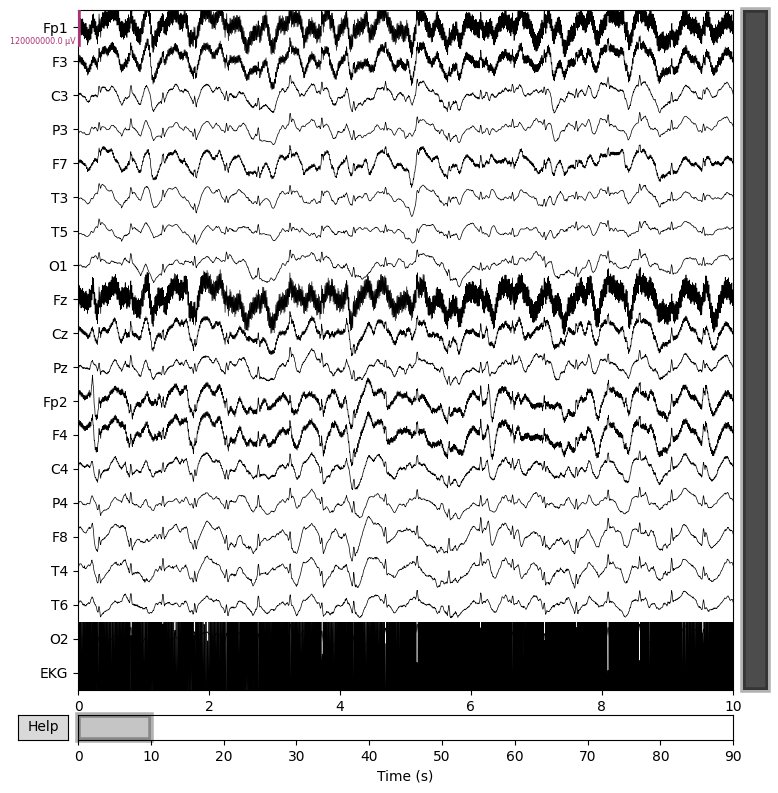

In [7]:
raw.plot(scalings={'eeg': 60})
plt.show()

Effective window size : 10.240 (s)


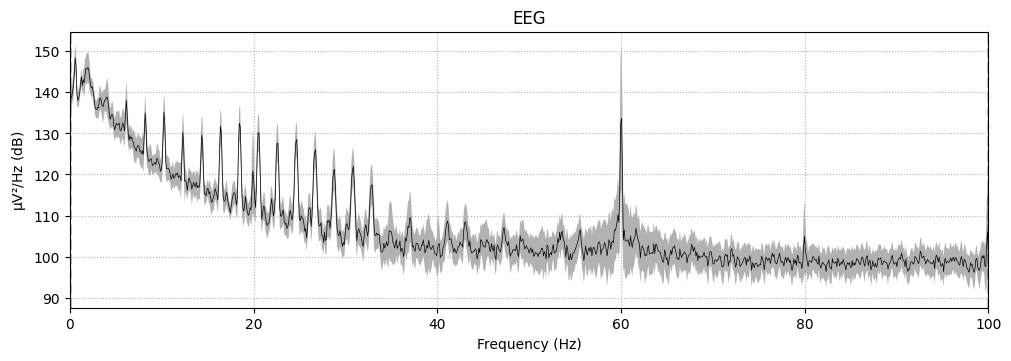

In [10]:
spectrum = raw.compute_psd()
spectrum.plot(average=True, picks="data", amplitude=False)
plt.show()

In [51]:
import numpy as np
import mne
from scipy.stats import skew, kurtosis
from scipy.signal import butter, filtfilt
from scipy.fftpack import fft
import pywt

# Define the frequency bands
frequency_ranges = {'Delta': (0.1, 4),
                    'Theta': (4, 8),
                    'Alpha': (8, 12),
                    'Beta': (12, 30),
                    'Gamma': (30, 100)}

# Define the statistical feature functions
def calculate_mean(data):
    return np.mean(data)

def calculate_variance(data):
    return np.var(data)

def calculate_skewness(data):
    return skew(data, axis=(0,1))

def calculate_kurtosis(data):
    return kurtosis(data, axis=(0,1))

# Define a function to apply Butterworth bandpass filter
def apply_bandpass_filter(data, fs, lowcut, highcut, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], fs=fs, btype='band')
    return filtfilt(b, a, data)

# Load EEG data into an MNE Raw object
# raw = mne.io.read_raw_fif('your_raw_data.fif', preload=True)

# Extract EEG data
data, times = raw[:, :]

# Initialize dictionary to store features
features = {}

# Iterate over frequency bands
for band, (low_freq, high_freq) in frequency_ranges.items():
    # Apply bandpass filter to extract data within frequency band
    filtered_data = apply_bandpass_filter(data, raw.info['sfreq'], low_freq, high_freq)
    
    # Calculate statistical features for time domain
    mean_td = calculate_mean(filtered_data)
    variance_td = calculate_variance(filtered_data)
    skewness_td = calculate_skewness(filtered_data)
    kurt_td = calculate_kurtosis(filtered_data)
    
    # Calculate statistical features for frequency domain (using FFT)
    fft_data = np.abs(fft(filtered_data))
    mean_fd = calculate_mean(fft_data)
    variance_fd = calculate_variance(fft_data)
    skewness_fd = calculate_skewness(fft_data)
    kurt_fd = calculate_kurtosis(fft_data)
    
    # Calculate statistical features for time-frequency domain (using wavelet transform)
    coeffs = pywt.wavedec(filtered_data, 'db6', level=4)
    
    wavelet_features = {'mean': [], 'variance': [], 'skewness': [], 'kurtosis': []}
    for coeff in coeffs:
        wavelet_features['mean'].append(calculate_mean(coeff))
        wavelet_features['variance'].append(calculate_variance(coeff))
        wavelet_features['skewness'].append(calculate_skewness(coeff))
        wavelet_features['kurtosis'].append(calculate_kurtosis(coeff))
    
    mean_tfd = np.mean(wavelet_features['mean'])
    variance_tfd = np.mean(wavelet_features['variance'])
    skewness_tfd = np.mean(wavelet_features['skewness'])
    kurt_tfd = np.mean(wavelet_features['kurtosis'])
    
    # Store features in dictionary
    features[band] = {'mean_td': mean_td,
                      'variance_td': variance_td,
                      'skewness_td': skewness_td,
                      'kurtosis_td': kurt_td,
                      'mean_fd': mean_fd,
                      'variance_fd': variance_fd,
                      'skewness_fd': skewness_fd,
                      'kurtosis_fd': kurt_fd,
                      'mean_tfd': mean_tfd,
                      'variance_tfd': variance_tfd,
                      'skewness_tfd': skewness_tfd,
                      'kurtosis_tfd': kurt_tfd}
                     
# Display the extracted features
for band, stats in features.items():
    print(f"Frequency Band: {band}")
    print(f"Time Domain:")
    print(f"Mean: {stats['mean_td']}")
    print(f"Variance: {stats['variance_td']}")
    print(f"Skewness: {stats['skewness_td']}")
    print(f"Kurtosis: {stats['kurtosis_td']}")
    print(f"Frequency Domain:")
    print(f"Mean: {stats['mean_fd']}")
    print(f"Variance: {stats['variance_fd']}")
    print(f"Skewness: {stats['skewness_fd']}")
    print(f"Kurtosis: {stats['kurtosis_fd']}")
    print(f"Time-Frequency Domain:")
    print(f"Mean: {stats['mean_tfd']}")
    print(f"Variance: {stats['variance_tfd']}")
    print(f"Skewness: {stats['skewness_tfd']}")
    print(f"Kurtosis: {stats['kurtosis_tfd']}")
    print("---------------------------")

Frequency Band: Delta
Time Domain:
Mean: -6.201239156705167e+33
Variance: 6.345148706932607e+70
Skewness: -28.060518943521615
Kurtosis: 894.4405553951096
Frequency Domain:
Mean: 2.152139280937952e+36
Variance: 1.138187260370729e+75
Skewness: 72.87578021344586
Kurtosis: 6507.046595438041
Time-Frequency Domain:
Mean: -6.916282572316832e+33
Variance: 3.3195360835297717e+71
Skewness: -9.099804252728962
Kurtosis: 29119.618127449845
---------------------------
Frequency Band: Theta
Time Domain:
Mean: -8.897440652607243e+35
Variance: 9.623005742256079e+74
Skewness: -27.316757451061363
Kurtosis: 881.4461504469585
Frequency Domain:
Mean: 2.8729355268197396e+38
Variance: 1.725312235167831e+79
Skewness: 73.56484438302985
Kurtosis: 6904.620924008605
Time-Frequency Domain:
Mean: -9.609409228843216e+35
Variance: 5.238365586049609e+75
Skewness: -9.700168471678818
Kurtosis: 28485.63398029135
---------------------------
Frequency Band: Alpha
Time Domain:
Mean: 22931020871965.734
Variance: 8.82272048210

In [11]:
stats['skewness_td'].shape

(18000,)

In [48]:
filt_raw = raw.copy().filter(l_freq=1.0, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [50]:
ica = ICA(n_components=len(filt_raw.ch_names), max_iter="auto", random_state=97)
ica.fit(filt_raw)
ica

Fitting ICA to data using 20 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.3s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,40 iterations on raw data (18000 samples)
ICA components,20
Available PCA components,20
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=20, n_times=18000
    Range : 0 ... 17999 =      0.000 ...    35.998 secs
Ready.


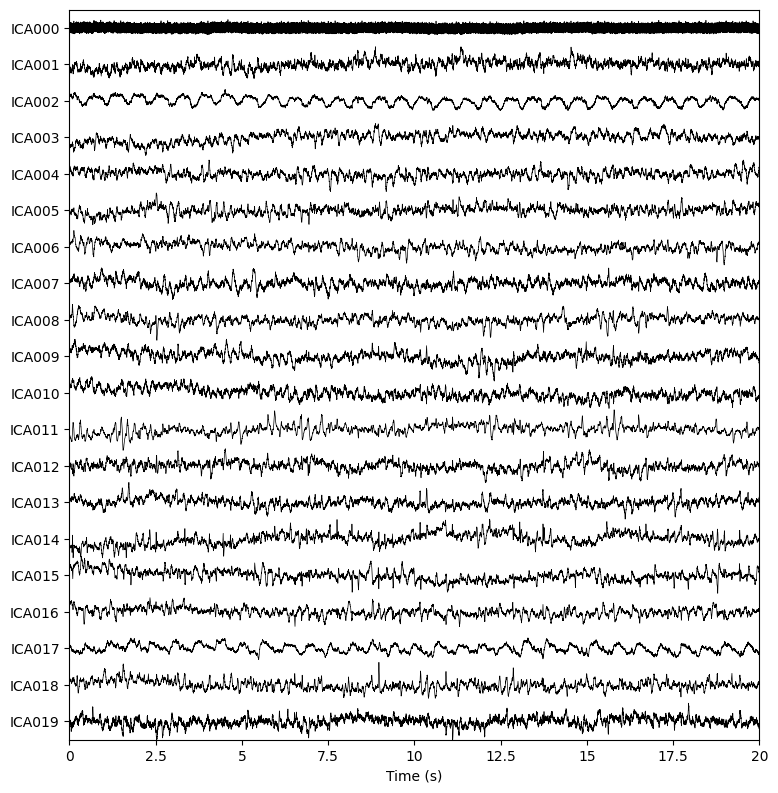

In [53]:
ica.plot_sources(raw, show_scrollbars=False)
plt.show()